In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Help functions for in here:
    
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#Next we perform the ANOVA on the dataframe
def ouranova(df,variable,sub_exclude='XX',exclude_fovea=True):
    if exclude_fovea:
        clause_exclude_fovea="PRL_Position_x!='foveal'"
    else:
        clause_exclude_fovea="True"
    wpm_data=df.query("(Training_x==False)&(Subject_ID!='%s')&%s"%(sub_exclude,clause_exclude_fovea)).groupby(['PRL_Position_x','Subject_ID']).mean()[variable].reset_index()

    data=wpm_data
    measure=variable
    aovrm=AnovaRM(data,measure,'Subject_ID',within=["PRL_Position_x"])

    res=aovrm.fit()

    print(res)


    #Followed by multiple comparison measures

    mc = MultiComparison(data[measure], data['PRL_Position_x'])
    result = mc.tukeyhsd()

    print(result)
    print(mc.groupsunique)

    from statsmodels.stats.libqsturng import psturng
    print (psturng(np.abs(result.meandiffs / result.std_pairs),len(result.groupsunique),result.df_total))
    
def oursave(fname):
    plt.savefig('figures/%s.pdf'%fname, bbox_inches='tight', transparent=True,dpi=600)
    plt.savefig('figures/%s.png'%fname, bbox_inches='tight', transparent=True,dpi=600)

In [3]:
os.chdir(r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects")
fixation_df=pd.read_csv('Fixation summary MNH DF 6 Subjects.txt',delimiter=',')
saccade_df=pd.read_csv('Saccade summary MNH DF 6 Subjects.txt',delimiter=',')

In [76]:
# Run this only to regenerate. Takes about 2-3 minutes.
# Can load saved (pickled) copies below.

regenerate=False

if regenerate:
    fixation_df['Page_Num']=0
    for i in range(len(fixation_df)):
        subject_id=fixation_df['Filename'][i][6:9]
        session_no=fixation_df['Filename'][i][10]
        trial_no=fixation_df['Filename'][i][fixation_df['Filename'][i].find('_T')+2:-4]
        page_num=fixation_df['Filename'][i][4]
        fixation_df.iloc[i,2]=str(subject_id)
        fixation_df.iloc[i,3]=str(session_no)
        fixation_df.iloc[i,4]=str(trial_no)
        fixation_df.iloc[i,13]=str(page_num)

    saccade_df['Page_Num']=0
    for i in range(len(saccade_df)):
        subject_id=saccade_df['Filename'][i][6:9]
        session_no=saccade_df['Filename'][i][10]
        trial_no=saccade_df['Filename'][i][saccade_df['Filename'][i].find('_T')+2:-4]
        page_num=saccade_df['Filename'][i][4]
        saccade_df.iloc[i,2]=str(subject_id)
        saccade_df.iloc[i,3]=str(session_no)
        saccade_df.iloc[i,4]=str(trial_no)
        saccade_df.iloc[i,20]=str(page_num)

    import tkinter as tk
    from tkinter import filedialog
    root = tk.Tk()
    root.withdraw()
    filedir_list=[]
    data_directory=(r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects")
    #data_directory=filedialog.askdirectory(title='Please select data directory')
    num_letters_dataframe=pd.DataFrame({'Filename':[],'PRL_Position':[],'Training':[],'Presentation_Mode':[],'Page_Number':[],'Number_Letters':[],'Number_Words':[],'Code':[]})
    num_letters_complete_list=[]
    num_words_complete_list=[]
    file_list=[]
    for root,dirs,files in os.walk(data_directory):
        filedir_list.append(root)

    for path in filedir_list:
        for filename in os.listdir(path):
            if 'reading_word_data' in filename and 'page' in filename:
                if filename.endswith('.png'): 
                    continue
                else:

                    file_list.append(filename)
                    if "inferior" in path.lower():
                        prl_position='inferior'
                    elif "left" in path.lower():
                        prl_position='left'
                    elif "right" in path.lower():
                        prl_position='right'

                    #identifies whether a word highlight was used or not
                    if "guides" in path.lower():
                        highlight='with highlight'
                    elif "foveal" in path.lower():
                        prl_position="foveal"
                        highlight="N/A"
                    else:
                        highlight='no highlight'

                    # identifies the page number of the trial
                    for page_number_idx in range(1,9):
                        page_number_reference='page%d'%(page_number_idx)
                        if  str(page_number_reference) in filename.lower():
                            page_num=page_number_idx

                    #identifies if it is a training session or main experiment
                    if "training" in path.lower():
                        training='True' # TODO: Remove quotes?
                    else:
                        training='False'
                    word_data_path=os.path.join(path,filename)
                    word_data=pd.read_csv(word_data_path,delimiter='\t',header=0)
                    num_letters_list=[]
                    num_words=len(word_data)
                    for word_idx in range(len(word_data)):
                        num_letters=len(word_data.iloc[word_idx,0])
                        num_letters_list.append(num_letters)
                    num_letters_trial=sum(num_letters_list)
                    num_letters_complete_list.append(num_letters_trial)
                    subject_id=filename[18:-10]
                    trial_code='%s%s%s%s%s'%(subject_id,'_',prl_position,'_',str(page_num))
                    num_letters_dataframe=num_letters_dataframe.append({'Filename':filename,'PRL_Position':prl_position,'Training':training,'Presentation_Mode':highlight,'Page_Number':page_num,'Number_Letters':num_letters_trial,'Number_Words':num_words,'Code':trial_code},ignore_index=True)

    def filename_to_code(x):
        return "%s_%s_%s"%(x.Filename[6:-4],x.PRL_Position.lower(),x.Page_Num)

    fixation_df["Code"]=fixation_df.apply(filename_to_code,1).astype(str)
    saccade_df["Code"]=saccade_df.apply(filename_to_code,1).astype(str)

    merged_df_fixation=pd.merge(fixation_df, num_letters_dataframe, left_on='Code', right_on='Code')
    merged_df_saccade =pd.merge(saccade_df, num_letters_dataframe, left_on='Code', right_on='Code')


    # Add some new columns
    merged_df_fixation["wpm"]=merged_df_fixation.Number_Words/merged_df_fixation.Trial_Duration*60000
    merged_df_saccade["ltor_word"]=merged_df_saccade.Number_of_forward_Saccades/ merged_df_saccade.Number_Words
    merged_df_saccade["rtol_word"]=merged_df_saccade.Number_of_backward_Saccades/ merged_df_saccade.Number_Words
    # merged_df_fixation.to_csv('fixation_df_sorted.txt')
    # merged_df_saccade.to_csv('saccade_df_sorted.txt')

    # Also save it to a pickle
    merged_df_fixation.to_pickle("./merged_df_fixation.pkl")
    merged_df_saccade.to_pickle("./merged_df_saccade.pkl")
else: # don't regen. Load from pickle
    merged_df_fixation=pd.read_pickle("./merged_df_fixation.pkl")
    merged_df_saccade=pd.read_pickle("./merged_df_saccade.pkl")

    merged_df_fixation.replace(to_replace=r"Foveal",value="foveal",inplace=True)
    merged_df_saccade.replace(to_replace=r"Foveal",value="foveal",inplace=True)

    fixation_main=merged_df_fixation.query('Training_x==False')
    saccade_main=merged_df_saccade.query('Training_x==False')


In [5]:
merged_df_fixation.PRL_Position_x.unique()

array(['inferior', 'foveal', 'left', 'right'], dtype=object)

In [6]:
print( merged_df_fixation.columns )
print( merged_df_saccade.columns )

Index([u'Unnamed: 0', u'Filename_x', u'Subject_ID', u'Session_No', u'Trial_No',
       u'Training_x', u'Training_Trial_Number', u'PRL_Position_x',
       u'Presentation_Mode_x', u'Mean_Fixation_Duration',
       u'SD_Fixation_Duration', u'Num_Fixations', u'Trial_Duration',
       u'Page_Num', u'Code', u'Filename_y', u'Number_Letters', u'Number_Words',
       u'PRL_Position_y', u'Page_Number', u'Presentation_Mode_y',
       u'Training_y', u'wpm'],
      dtype='object')
Index([u'Unnamed: 0', u'Filename_x', u'Subject_ID', u'Session_No', u'Trial_No',
       u'Training_x', u'Training_Trial_Number', u'PRL_Position_x',
       u'Presentation_Mode_x', u'Mean_Saccade_Duration',
       u'SD_saccade_duration', u'Number_of_saccades',
       u'Number_of_forward_Saccades', u'Number_of_backward_Saccades',
       u'Mean_Saccade_Amplitude_H_Forward', u'SD_Saccade_Amplitude_H_Forward',
       u'Mean_Saccade_Amplitude_H_Backward',
       u'SD_Saccade_Amplitude_H_Backward', u'Mean_Saccade_Amplitude_V',
   

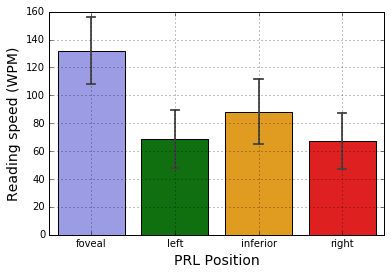

In [7]:
# These are okay colors
my_pal = {"left": "g", "right": "r", "inferior": "orange", "foveal":"#9090f0"}
my_order = ['foveal', 'left', 'inferior', 'right']

#plt.figure(figsize=(15,6))
sns.barplot(data=fixation_main, y='wpm', x='PRL_Position_x', ci='sd', capsize=0.1, order=my_order, palette=my_pal )
plt.ylabel('Reading speed (WPM)', size=14)
plt.xlabel('PRL Position', size=14)
plt.grid()
oursave('wpm_summary')

In [8]:
ouranova(fixation_main,'wpm',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 77.7219 3.0000 15.0000 0.0000

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
 foveal  inferior -43.6588 -60.9456 -26.372   True 
 foveal    left   -63.3364 -80.6232 -46.0496  True 
 foveal   right   -64.7445 -82.0313 -47.4577  True 
inferior   left   -19.6775 -36.9643 -2.3907   True 
inferior  right   -21.0857 -38.3725 -3.7989   True 
  left    right   -1.4081  -18.6949 15.8786  False 
---------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.001       0.001       0.001       0.0221412   0.01346278  0.9       ]


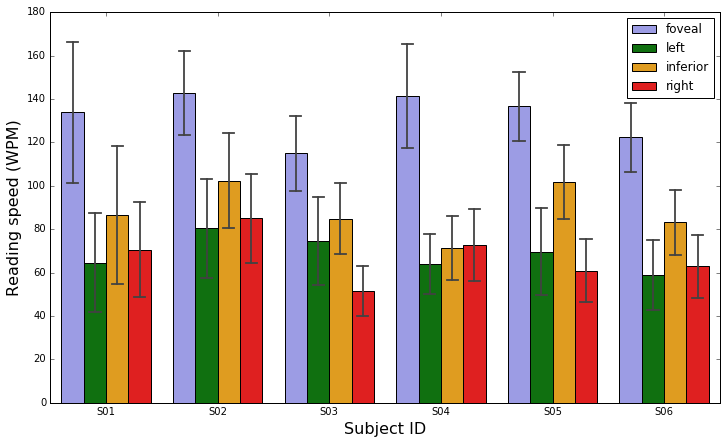

In [9]:
#sns.set_palette("muted")
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.set_palette(['orange','gray','g','#ff1010'])

plt.figure(figsize=(12,7))
sns.barplot(data=fixation_main, y='wpm', x='Subject_ID', ci='sd',hue='PRL_Position_x', capsize=0.1,
            hue_order=my_order, palette=my_pal,  )
plt.legend(loc='upper right')
plt.ylabel('Reading speed (WPM)', size=16)
plt.xlabel('Subject ID', size=16)

# TODO: copy values from Krish Expt.

#plt.plot( [-0.5, 7,], [120,120], 'g--',lw=3, alpha=0.5 )

oursave('wpm_all')

In [10]:
ouranova(saccade_main,'Number_of_forward_Saccades',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 11.3853 3.0000 15.0000 0.0004

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 foveal  inferior  0.5406  -1.0167 2.0979 False 
 foveal    left    3.2799   1.7226 4.8372  True 
 foveal   right    1.9531   0.3958 3.5104  True 
inferior   left    2.7393   1.1819 4.2966  True 
inferior  right    1.4125  -0.1448 2.9698 False 
  left    right   -1.3268  -2.8841 0.2306 False 
------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.74646673  0.001       0.0108795   0.001       0.08407224  0.11267501]


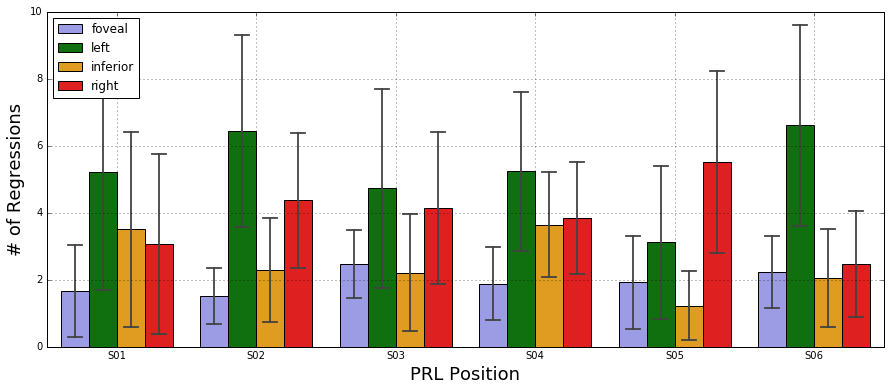

In [11]:
# NOT SURE if will use this...

plt.figure(figsize=(15,6))
sns.barplot(data=saccade_main, y='Number_of_forward_Saccades', x='Subject_ID', ci='sd',
            capsize=0.1,palette=my_pal, hue='PRL_Position_x', hue_order=my_order)

plt.legend(loc='upper left')
plt.ylabel('# of Regressions', size=18)
plt.xlabel('PRL Position', size=18)

plt.grid()

oursave("regressions")

In [12]:
ouranova(saccade_main,'Number_of_forward_Saccades',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 11.3853 3.0000 15.0000 0.0004

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 foveal  inferior  0.5406  -1.0167 2.0979 False 
 foveal    left    3.2799   1.7226 4.8372  True 
 foveal   right    1.9531   0.3958 3.5104  True 
inferior   left    2.7393   1.1819 4.2966  True 
inferior  right    1.4125  -0.1448 2.9698 False 
  left    right   -1.3268  -2.8841 0.2306 False 
------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.74646673  0.001       0.0108795   0.001       0.08407224  0.11267501]


C:\Users\C-LAB\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


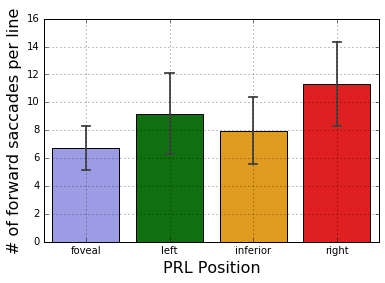

In [13]:
# NOT SURE if will use this...

#plt.figure(figsize=(15,6))
sns.barplot(data=saccade_main, y='Number_of_backward_Saccades', x='PRL_Position_x', ci='sd',
            capsize=0.1,palette=my_pal,order=my_order)

plt.legend(loc='upper left')
plt.ylabel('# of forward saccades per line', size=16)
plt.xlabel('PRL Position', size=16)

plt.grid()

oursave("forward_summary")

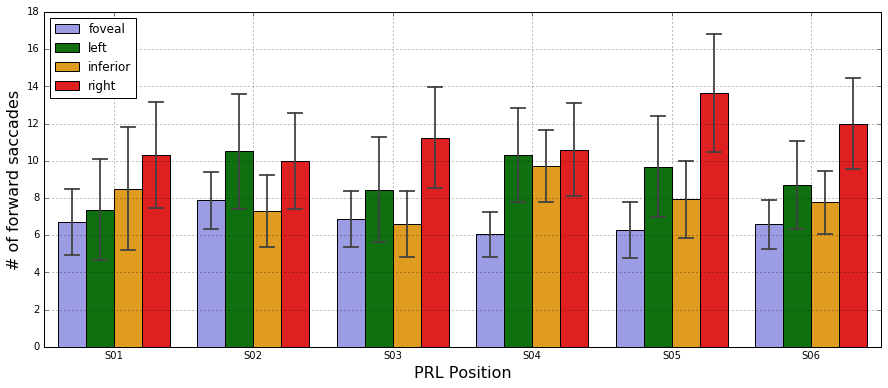

In [14]:
plt.figure(figsize=(15,6))
sns.barplot(data=saccade_main, y='Number_of_backward_Saccades', x='Subject_ID', ci='sd',
            capsize=0.1,palette=my_pal, hue='PRL_Position_x', hue_order=my_order)

plt.legend(loc='upper left')
plt.ylabel('# of forward saccades', size=16)
plt.xlabel('PRL Position', size=16)

plt.grid()

oursave("forward saccades")

In [15]:
ouranova(saccade_main,'Number_of_backward_Saccades',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 17.1164 3.0000 15.0000 0.0000

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 foveal  inferior  1.2427  -0.5397 3.0251 False 
 foveal    left    2.4489   0.6665 4.2313  True 
 foveal   right    4.576    2.7937 6.3584  True 
inferior   left    1.2062  -0.5762 2.9886 False 
inferior  right    3.3333   1.5509 5.1157  True 
  left    right    2.1271   0.3447 3.9095  True 
------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.23922361  0.00513039  0.001       0.26202449  0.001       0.01582896]


In [16]:
# Manual aggregation (vs. Seaborn)

# variable='wpm'
# wpm_data=fixation_main.query("(Training_x==False)").groupby(['PRL_Position_x']).mean()[variable]
# error_bar=fixation_main.query("(Training_x==False)").groupby(['PRL_Position_x'])[variable].std()

# wpm_data.plot(kind='bar',yerr=error_bar,capsize=5,color=(0.2, 0.4, 0.6, 0.6))
# plt.ylabel('Words Per Minute (WPM)',size=14)
# plt.xlabel('PRL Position',size=14)
# plt.title('Reading Speed & PRL Position')
# plt.ylim(30,210)
# plt.yticks((30,60,90,120,150,180,210))
# plt.grid()
#savefig('Reading Speed Scaled.pdf',bbox_inches='tight')

# wpm_data=fixation_main.query("(Training_x==False)").groupby(['PRL_Position_x','Subject_ID']).mean()[variable].reset_index()
# plt.figure(figsize=(15,6))
# sns.barplot(data=wpm_data, y='wpm', x='PRL_Position_x')

# from scipy import stats
# stats.ttest_rel(training_summary['Reading_speed_start'],training_summary['Reading_speed_end'], axis=0, nan_policy='propagate')

In [17]:
# variable='rtol_word'
# variable='Number_of_forward_Saccades'
# #foveal_data=merged_df_saccade.query("(Training_x==False) & PRL_Position_x=='Foveal'").mean()[variable]
# backward_saccade_data=merged_df_saccade.query("(Training_x==False) & Subject_ID!='S09' ").groupby(['PRL_Position_x']).mean()[variable]
# error_bar=merged_df_saccade.query("(Training_x==False)").groupby(['PRL_Position_x'])[variable].std()

# backward_saccade_data.plot(kind='bar',yerr=error_bar,capsize=5,color=(0.2, 0.4, 0.6, 0.6))
# plt.ylabel('Number of forward saccades',size=14)
# #plt.ylim(0,20)
# plt.xlabel('PRL Position',size=14)
# #plt.title('Number of forward saccades & PRL Position')

# plt.plot([-0.5,3.5],[1,1], 'k--')
# plt.grid()

# # TODO: Do statistical tests

In [18]:
# variable='ltor_word'
# #foveal_data=merged_df_saccade.query("(Training_x==False) & PRL_Position_x=='Foveal'").mean()[variable]
# #gb=merged_df_saccade.query("(Training_x==False) & Subject_ID!='xx' ") #.groupby(['PRL_Position_x'])
# error_bar=saccade_main.groupby(['PRL_Position_x'])[variable].std()
# backward_saccade_data=saccade_main.groupby(['PRL_Position_x']).mean()[variable]

# backward_saccade_data.plot(kind='bar',yerr=error_bar,capsize=5,color=(0.2, 0.4, 0.6, 0.6))
# plt.ylabel('Number of backward saccades\nper word',size=14)
# #plt.ylim(0,20)
# plt.xlabel('PRL Position',size=14)
# #plt.title('Number of forward saccades & PRL Position')

# plt.plot([-0.5,3.5],[1,1], 'k--')
# plt.grid()
# #plt.savefig('figures/Backward_prl_pos.pdf',bbox_inches='tight')
# oursave("regressions_summary")
# # TODO: Do statistical tests

In [19]:
saccade_main.columns

Index([u'Unnamed: 0', u'Filename_x', u'Subject_ID', u'Session_No', u'Trial_No',
       u'Training_x', u'Training_Trial_Number', u'PRL_Position_x',
       u'Presentation_Mode_x', u'Mean_Saccade_Duration',
       u'SD_saccade_duration', u'Number_of_saccades',
       u'Number_of_forward_Saccades', u'Number_of_backward_Saccades',
       u'Mean_Saccade_Amplitude_H_Forward', u'SD_Saccade_Amplitude_H_Forward',
       u'Mean_Saccade_Amplitude_H_Backward',
       u'SD_Saccade_Amplitude_H_Backward', u'Mean_Saccade_Amplitude_V',
       u'SD_Saccade_Amplitude_V', u'Page_Num', u'Code', u'Filename_y',
       u'Number_Letters', u'Number_Words', u'PRL_Position_y', u'Page_Number',
       u'Presentation_Mode_y', u'Training_y', u'ltor_word', u'rtol_word'],
      dtype='object')

In [20]:
ouranova(saccade_main,'rtol_word','x',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 16.8933 3.0000 15.0000 0.0000

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 foveal  inferior  0.2209  -0.0994 0.5412 False 
 foveal    left    0.4383   0.118  0.7586  True 
 foveal   right    0.8203    0.5   1.1406  True 
inferior   left    0.2174  -0.1029 0.5377 False 
inferior  right    0.5993   0.279  0.9196  True 
  left    right    0.3819   0.0616 0.7022  True 
------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.24729632  0.00531262  0.001       0.25981404  0.001       0.01592406]


In [21]:
ouranova(saccade_main,'ltor_word','x',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 10.6418 3.0000 15.0000 0.0005

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 foveal  inferior  0.1004   -0.183 0.3837 False 
 foveal    left    0.5792   0.2958 0.8625  True 
 foveal   right    0.3458   0.0625 0.6292  True 
inferior   left    0.4788   0.1954 0.7622  True 
inferior  right    0.2455  -0.0379 0.5289 False 
  left    right   -0.2333  -0.5167  0.05  False 
------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.73576444  0.001       0.01340236  0.001       0.10441973  0.13035411]


In [22]:
ouranova(saccade_main,'Mean_Saccade_Amplitude_H_Backward',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 10.9188 3.0000 15.0000 0.0005

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 foveal  inferior  0.6368  -0.0333  1.307  False 
 foveal    left    -0.563  -1.2331  0.1072 False 
 foveal   right    0.6127  -0.0574  1.2829 False 
inferior   left   -1.1998   -1.87  -0.5297  True 
inferior  right   -0.0241  -0.6943  0.6461 False 
  left    right    1.1757   0.5056  1.8459  True 
-------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.06625008  0.11986978  0.08079128  0.001       0.9         0.001     ]


In [23]:
# chars_per_degree=1./(1.36 * 0.52)
# saccade_main["sacc_fwd_chars"]=np.abs(saccade_main.Mean_Saccade_Amplitude_H_Backward)*chars_per_degree
chars_per_degree=1./(1.36 * 0.52)
saccade_main["sacc_fwd"]=np.abs(saccade_main.Mean_Saccade_Amplitude_H_Backward)

C:\Users\C-LAB\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


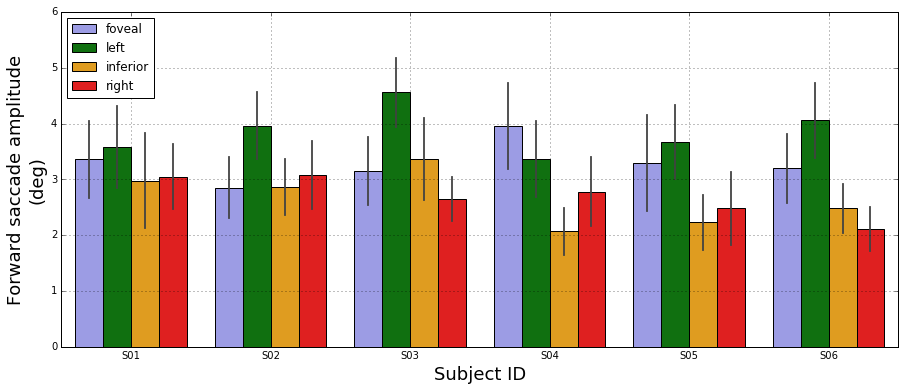

In [24]:
plt.figure(figsize=(15,6))
#gb.Mean_Saccade_Amplitude_H_Backward = np.abs(gb.Mean_Saccade_Amplitude_H_Backward)
sns.barplot(data=saccade_main,x='Subject_ID',y="sacc_fwd",ci='sd',hue='PRL_Position_x', hue_order=my_order, palette=my_pal)
plt.ylabel('Forward saccade amplitude\n(deg)', size=18)
plt.xlabel('Subject ID', size=18)
plt.legend(loc='upper left')
plt.grid()
oursave('forward_amplitude')

In [25]:
ouranova(saccade_main,'sacc_fwd',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 10.9188 3.0000 15.0000 0.0005

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 foveal  inferior -0.6368   -1.307  0.0333 False 
 foveal    left    0.563   -0.1072  1.2331 False 
 foveal   right   -0.6127  -1.2829  0.0574 False 
inferior   left    1.1998   0.5297   1.87   True 
inferior  right    0.0241  -0.6461  0.6943 False 
  left    right   -1.1757  -1.8459 -0.5056  True 
-------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.06625008  0.11986978  0.08079128  0.001       0.9         0.001     ]


# Fixation duration

C:\Users\C-LAB\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


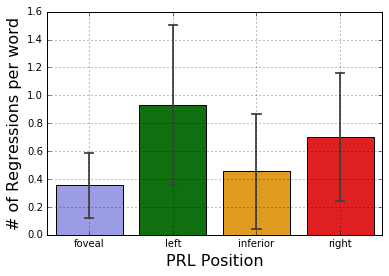

In [26]:
# NOT SURE if will use this...

#plt.figure(figsize=(15,6))
sns.barplot(data=saccade_main, y='ltor_word', x='PRL_Position_x', ci='sd',
            capsize=0.1,palette=my_pal,order=my_order)

plt.legend(loc='upper left')
plt.ylabel('# of Regressions per word', size=16)
plt.xlabel('PRL Position', size=16)

plt.grid()

oursave("regressions_summary")

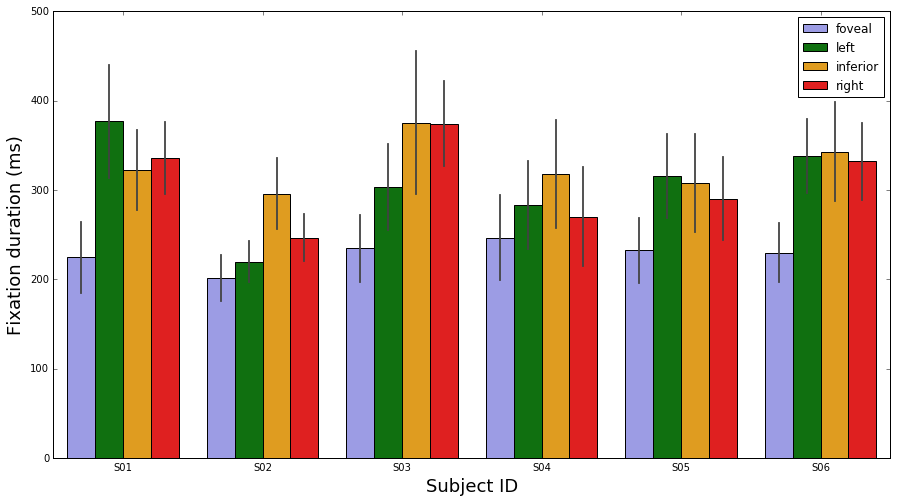

In [27]:
plt.figure(figsize=(15,8))
sns.barplot(data=fixation_main,x='Subject_ID',y='Mean_Fixation_Duration',ci='sd',
            hue='PRL_Position_x',hue_order=my_order, palette=my_pal)
#sns.barplot(data=fixation_main,x='PRL_Position_x',y='Mean_Fixation_Duration',ci='sd',hue='Subject_ID')
plt.xlabel('Subject ID', size=18)
plt.ylabel('Fixation duration (ms)', size=18)
plt.legend(loc='upper right')
oursave("fixation_duration")

In [28]:
ouranova(fixation_main,'Mean_Fixation_Duration',exclude_fovea=False)

                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
PRL_Position_x 14.0620 3.0000 15.0000 0.0001

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
 foveal  inferior 98.6454   35.506  161.7848  True 
 foveal    left   77.9484   14.809  141.0879  True 
 foveal   right   79.8264   16.687  142.9659  True 
inferior   left   -20.6969 -83.8363 42.4425  False 
inferior  right   -18.8189 -81.9583 44.3205  False 
  left    right    1.878   -61.2614 65.0174  False 
---------------------------------------------------
['foveal' 'inferior' 'left' 'right']
[ 0.00154489  0.01228847  0.01021887  0.77602529  0.82144894  0.9       ]


In [29]:
# sns.barplot(data=gb,x='PRL_Position_x',y='ltor_word',ci='sd')
# plt.ylabel('Number of backward saccades\nper word',size=14)
# #plt.ylim(0,20)
# plt.xlabel('PRL Position',size=14)
# #plt.title('Number of forward saccades & PRL Position')

# plt.plot([-0.5,3.5],[1,1], 'k--')
# plt.grid()

In [30]:
# # TODO (graphs)
# - training plots
# - accuracy (vs. speed, vs. PRL position)
# - saccade amplitude units
# - fixation duration units

# # t-tests

In [31]:
# Now we compare the training effect by looking at the reading speeds:
#Start of training vs end of training
df_dropped=merged_df_fixation.drop(7032)

training_start=df_dropped.query("(Training_x==True)")['wpm']

subject_list=["S01","S02","S03","S04","S05","S06"]
prl_list=["inferior","right","left"]
training_summary=pd.DataFrame({'Subject_ID':[],'PRL_Position':[],'Reading_speed_start':[],'Reading_speed_end':[],'Difference':[]})
for i in range(len(subject_list)):
    for j in range(len(prl_list)):
        subject_id=subject_list[i]
        prl_pos=prl_list[j]
        training_starting_performance=np.mean(df_dropped.query(
            "(Training_x==True) & (PRL_Position_x==@prl_pos)&(Subject_ID==@subject_id)& Trial_No=='0'"))['wpm']
        training_ending_performance=np.mean(df_dropped.query("(Training_x==True) & (PRL_Position_x==@prl_pos)&(Subject_ID==@subject_id)& Trial_No=='39'")['wpm'])
        training_effect=training_ending_performance/training_starting_performance
        training_summary=training_summary.append({'Subject_ID':subject_id,'PRL_Position':prl_pos,'Reading_speed_start':training_starting_performance,'Reading_speed_end':training_ending_performance,'Difference':training_effect},ignore_index=True)
        
print(training_summary)
#training_start=np.mean()
training_ratio=np.mean(training_summary['Reading_speed_end'])/np.mean(training_summary['Reading_speed_start'])
print(training_ratio)


from scipy import stats

stats.ttest_rel(training_summary['Reading_speed_start'],training_summary['Reading_speed_end'], axis=0, nan_policy='propagate')



    Difference PRL_Position  Reading_speed_end  Reading_speed_start Subject_ID
0     2.710680     inferior         110.950040            40.930700        S01
1     2.397894        right          94.582725            39.444083        S01
2     2.004883         left          63.749447            31.797092        S01
3     1.257823     inferior         116.337247            92.490989        S02
4     1.841002        right         109.211275            59.321636        S02
5     1.588261         left          69.682751            43.873613        S02
6     2.302288     inferior          95.585743            41.517720        S03
7     2.373711        right          56.473605            23.791274        S03
8     2.199317         left          84.250434            38.307539        S03
9     3.511910     inferior          48.300755            13.753415        S04
10    2.033947        right          82.003803            40.317577        S04
11    2.038994         left          74.950329      

Ttest_relResult(statistic=-10.585964421802823, pvalue=6.6773704437551865e-09)

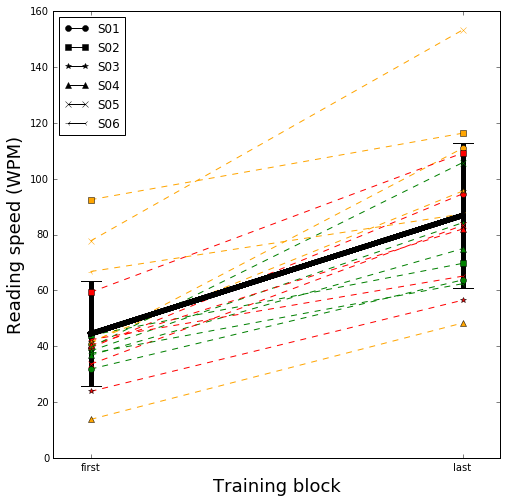

In [32]:
plt.figure(figsize=(8,8))

sub_sym={'S01':'o', 'S02': 's','S03': '*', 'S04':'^','S05':'x','S06':'3'}

for apt in range(18):
    row=training_summary.iloc[apt]
    if apt%3==0:
        plt.plot( (-1,-1), (100,100), color='k', marker=sub_sym[row.Subject_ID], label=row.Subject_ID)

    plt.plot( (0,1), (row['Reading_speed_start'], row['Reading_speed_end']) ,'o--',
            color=my_pal[row.PRL_Position], marker=sub_sym[row.Subject_ID] )

    plt.errorbar( (0,1), (training_summary['Reading_speed_start'].mean(), training_summary['Reading_speed_end'].mean()) ,
        yerr=(training_summary['Reading_speed_start'].std(), training_summary['Reading_speed_end'].std()),
             lw=5, color='k', capsize=10 )

plt.xlim(-0.1,1.1)
plt.xticks( [0,1], ["first", "last"])
plt.ylabel("Reading speed (WPM)", size=18)
plt.xlabel("Training block", size=18)

plt.legend(loc='upper left')

oursave("Traning_lines")

In [33]:
print(training_summary.Difference.mean())

2.10588193886


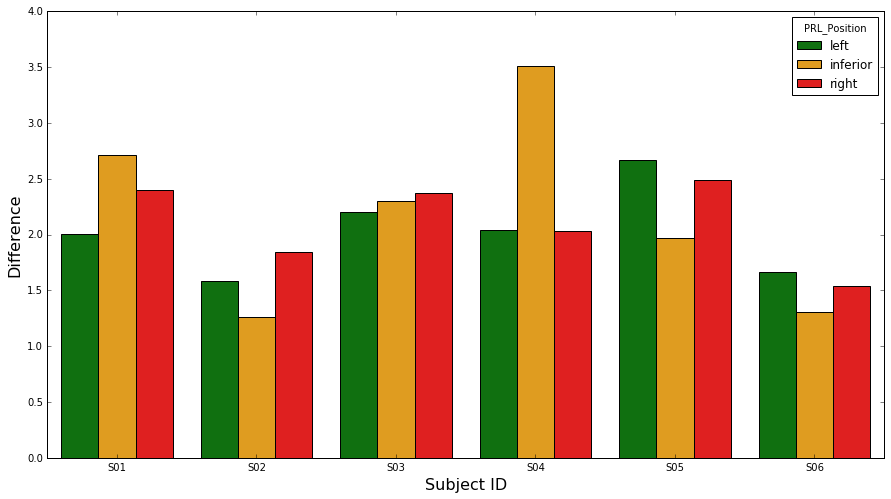

In [34]:
plt.figure(figsize=(15,8))
sns.barplot(data=training_summary,x='Subject_ID',y='Difference',ci='sd',
            hue='PRL_Position',hue_order=my_order[1:], palette={'inferior': 'orange', 'left': 'g', 'right': 'r'})
plt.xlabel('Subject ID', size=16)
plt.ylabel('Difference', size=16)

oursave("Training_Summary")

In [35]:
my_pal['left']

'g'

In [36]:
merged_df_saccade.columns

Index([u'Unnamed: 0', u'Filename_x', u'Subject_ID', u'Session_No', u'Trial_No',
       u'Training_x', u'Training_Trial_Number', u'PRL_Position_x',
       u'Presentation_Mode_x', u'Mean_Saccade_Duration',
       u'SD_saccade_duration', u'Number_of_saccades',
       u'Number_of_forward_Saccades', u'Number_of_backward_Saccades',
       u'Mean_Saccade_Amplitude_H_Forward', u'SD_Saccade_Amplitude_H_Forward',
       u'Mean_Saccade_Amplitude_H_Backward',
       u'SD_Saccade_Amplitude_H_Backward', u'Mean_Saccade_Amplitude_V',
       u'SD_Saccade_Amplitude_V', u'Page_Num', u'Code', u'Filename_y',
       u'Number_Letters', u'Number_Words', u'PRL_Position_y', u'Page_Number',
       u'Presentation_Mode_y', u'Training_y', u'ltor_word', u'rtol_word'],
      dtype='object')

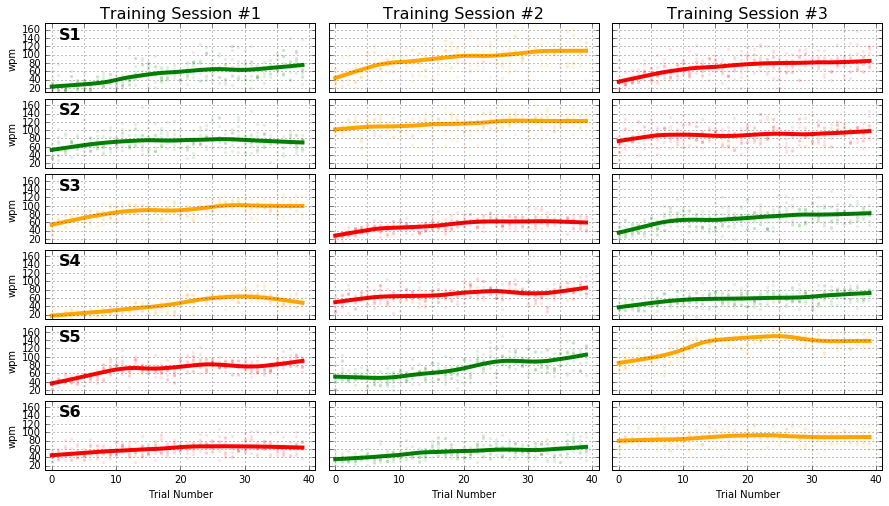

In [37]:
df=merged_df_fixation
outcome='wpm'

#df=merged_df_saccade
#outcome='rtol_word'

#outcome='fixations_per_word'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJIAAAFNCAYAAABbvUVCAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xl8U1X+//HXp6VlESzigiICMi6IgGAFW0BsKW6ooIg6WAHXzowywIiMC8sgWHVmGEX0p44Li1jBBXFBXGZKCypRBAEZwPm6teCgCArIIq3Q8/sjaS2lTdM2aZL2/Xw88kjuzc25n5NgPvaTc88x5xwiIiIiIiIiIiKViQl3ACIiIiIiIiIiEh1USBIRERERERERkYCokCQiIiIiIiIiIgFRIUlERERERERERAKiQpKIiIiIiIiIiAREhSQREREREREREQmICklSZ5lZOzNzZtYg3LEEi5ldbmabzGy3mXWrxuvvNrOnQxGbiEhdUVfyhy9XtA/wWGdmJ4U6JhGRuqiu5I2KmNkfzGyLL68cGe54JPxUSJKQMbM8M/vZ94WzxcxmmlnTcMcViFLJYLfvlmdmd5Z63pnZHt9z/zOzB80sttTzuWZ2UwDnSTGzb6oQ2lRghHOuqXNuVdV6Bc65+5xzlcYlIhJOyh8B548iXzu7zOy/ZnZ96WN8ueKrIPTpOjN7v6btiIiEivJGSP7uKH5dHPAgcL4vr/ygHx9EhSQJtUudc02BM4HuwPgwx1NVzX3xDwEmmtmFpZ47w/fcucDVwA21EE9bYF11XliTX0jq6q8rIhLRlD8qt9nXzuHAn4CnzOzUmgQtIhLFlDdCoyXQiGr+DSJ1kwpJUiucc/8D3gI6Qcmvm1/5fkX92szSi481sxvMbIOZbTezd8ysrW//IUNGS1fgzSzWzKaa2TYz+wq4uHQMZtbKzF43sx/N7Aszu7kK8Xvwfnl2Kue5L4APgK5VeEvK5evPFDP7wPfevGtmR5lZQzPbDcQCa8zsy1J9mm9mW33v48hSbU0ys5fN7Dkz+wm4zrfvuVLHDDCzdWa2w3fu00o9l2dmd5jZp8AeFZNEJByUPwI6h3POLQJ+BLqUirvkF2MzO9LM3jCzn8zsYzO7t5xRRv3M7HPf+/f/zOs04Akg2fdr+I6axCoiEmrKG1Xn+1tjqpltNO+IrifMrLGZnQL813fYDjNbbGZLfdtrfHnh6mDGItFBhSSpFWZ2AtAfWGVmhwHTgYucc82AnsBq33GXAXcDg4CjgfeAuQGe5mbgEqAbcBYwuMzzc4FvgFa+5+4zs7QAYjcz6wWcDhxyOZmZdQDOAb4IMM7KXANcDxwDxAO3O+cKfL9CgPcXid+YWQzwBrAGOB5IA0ab2QWl2hoIvAw0B7LKxH0K3vdkNN73ehHwhpnFlzpsCN7E2Nw5tz9I/RMRCZjyR+XMLMbMBgBH+Wnr/wF7gGOB4b5bWZfg/RX/DOAq4ALn3Abg94DHd0lD85rEKiISasob1fJX4BS8BaqT8P5tMdE593++WMD790Bf51wf3/YZvrzwQpBjkSigQpKE2qu+Xy/fB5YA9/n2FwGdzKyxc+5b51zxUMnfAfc75zb4Chf3AV2Lfx2oxFXANOfcJufcj8D9xU/4Ekpv4A7n3D7n3GrgaWBoJW1uw/sL79PAnc657FLPfWJme4ANQC7wWAAxBmKmc+7/nHM/Ay9S8S8O3YGjnXOTnXOFvnkwngJ+W+oYj3PuVedcka+90q4G3nTO/cs59wve+Zca402wxab73s+yrxURCTXlj8q18r1HPwMLgNvKmz/PvHNpXAH8xTm31zm3HphdTnsPOOd2OOc2AjkE+RdvEZEQU96oBjMzvIWxPznnfnTO7cL7XvzW/yulPlMhSULtMudcc+dcW+fcLc65n51ze/AWMX4PfGtmb/qq6+CdA+hh815qtQPvl6nhrYpXphWwqdR2fpnnir8YSz9/PJSsbFN8a1PqmKOcc0c4505zzk0vc74zgaa+vpwNHBZAjIH4rtTjvb5zlKctvj8iSr1fd+O9jrnYpvJfCnjfk5L3yDlX5Du+9Hvt7/UiIqGk/FG5zb4RQofj/cW9bwXHHQ004OA+lvf9Hmj+ERGJRMob1XM00ARYWeq9eNu3X6RcKiRJWDjn3nHOnQccB3yGdyQNeL+Qf+dLAsW3xs65ZXiH5IP3i67YsaUefwucUGq79BfzZqCFmTUr8/z/fPE0LXXbWIV+OOfci4AHmBjo64JkE/B1mfeqmXOuf+kQ/bx+M94ECpT8GnECvvckgNeLiNQ65Y9y2yoA7gA6+y7VKGsrsB9oXWrfCeUcV+EpahCeiEhYKW9Uahveka2nl3ofEtyv02qIHEKFJKl1ZtbSvJM8HwYUALuBA76nnwDuMrPTfccmmNmVAM65rXi/gK/1TXB3A/CbUk2/CIw0s9ZmdgRQsmymc24TsAy438wamVkX4EbKzBtUAw8AGWZWOsE08J2r+BYXpHMVWw78ZN4JsRv73pNOZtY9wNe/CFxsZmm+2Mbg/TyWBTlOEZGgUP6omHOuEPgH5fxx4Zw7ALwCTDKzJr5f44dVIcYtQOsyc+iJiEQ85Y1DlTmuEd4fC54CHjKzY3zHHG8Hz7ta1hagfRD6IlFKhSQJhxi8RYvNeIeQngvcAuCcW4B3srd55l1p7D/ARaVeezMwFvgB78RvpYseTwHv4J18+hO8/9Nc2hCgne+8C/DOFfGvYHTIObcW77XYY0vtfhxvdb/4NjMY5yp1zgPApXjnsPga768JTwMJAb7+v8C1wCO+116Kd9nUwmDGKSISRMof/s0A2pjZpeU8NwJvfvgOmIN3ItiCANtdjHcFoe/MbFuArxERiQTKGwc7vsxxP+MtkN2BdwLvD33vxb+BU/2EMQmY7bsU7qpqd0ailjmn0coiIiIi9YmZ/RU41jlX3uptIiIiIhXSiCQRERGROs7MOphZF/PqgfcyiwXhjktERESiT8gKSb5rLpeb2RozW2dm95RzTEMze8HMvjCzj8ysXajiERGRyKI8IVKrmuG99GIP3rk9/gG8FtaIRCqhPCEiEpkahLDtAqCvc263b7Kv983sLefch6WOuRHY7pw7ycx+i/ca1atDGJOIiEQO5QmRWuKc+xg4KdxxiFSR8oSISAQK2Ygk3/KEu32bcb5b2QmZBgKzfY9fBtLMzEIVk4iIRA7lCRER8Ud5QkQkMoV0jiTfUomrge+BfznnPipzyPHAJgDn3H5gJ3BkKGMSEZHIoTwhIiL+KE+IiESeUF7aVrw8eVczaw4sMLNOzrn/lDqkvF8LDllGzswygAyAxo0bJ55wwgkHPV9UVERMTN2aN1x9ig7qU3SoL336v//7v23OuaPDFFK1KE9Un/oUHdSn6FBf+qQ8cXCeiPvpJxpt2QKlV7E2Y1/Llvxy+OFB7Uc41Jd/19FOfYoO9aVPAecJ51yt3IC/ALeX2fcOkOx73ADYBpi/dhITE11ZOTk5h+yLdupTdFCfokN96ROwwtXSd3oobsoTVaM+RQf1KTrUlz4pT5STJ557zrm2bV2RmXNt23q364j68u862qlP0aG+9CnQPBHKVduO9v1ygJk1BvoBn5U57HVguO/xYGCxL3gREanjlCdERMSfWskT6emQl8eSxYshL8+7LSIifoXy0rbjgNlmFot3LqYXnXMLzWwy3irX68AzwBwz+wL4EfhtCOMREZHIojwhIiL+KE+IiESgkBWSnHOfAt3K2T+x1ON9wJWhikFERCKX8oSIiPijPCEiEplCOtm2iESXX375haZNm7Jhw4ZwhxJUCQkJdapPjRo1Qisbi0g4KE9EB+UJEQkX5YnoUNM8oUKSiJT45ptvaNmyJa1bt65T/wO6a9cumjVrFu4wgsI5xw8//MBhhx0W7lBEpB5Snoh8yhMiEk7KE5EvGHmibq1fJyI1sm/fPhISEurUl35dY2YceeSRxMbGhjsUEamHlCcin/KEiIST8kTkC0aeUCFJRA6iL/3Ip89IRMJJ30GRT5+RiISTvoMiX00/IxWSRCSimBljxowp2Z46dSqTJk0K+PWzZs1ixIgRB+3r378/K1asKHm8Y8cOv22kpKSUHF9abm4ul1xyCQCvv/46DzzwgN92Sh9f1rRp09i7d6/f14uIyMH+9Kc/MW3atJLtCy64gJtuuqlke8yYMTz44INs3ryZwYMHA7B69WoWLVpUcsykSZOYOnVqpedq164d27ZtK9kOZg4onWdqkpfK9k1EpL5TnjhYqPKECkkiElEaNmzIK6+8ctCXcjAtWrSI5s2b17idAQMGcOedd1b79SokiYhUXc+ePVm2bBkARUVFbNu2jXXr1pU8v2zZMnr16kWrVq14+eWXgdD8T3RNc0BpNclLKiSJiBxMeeJgKiSJSL3QoEEDMjIyeOihhw55Lj8/n7S0NLp06UJaWhobN26scvulfzmYMmUKHTp04LzzzmPIkCEH/fLw0ksv0aNHD0455RTee++9Q9opPfLpyy+/JCkpie7duzNx4kSaNm1actzu3bsZPHgwHTp0ID09Hecc06dPZ/PmzaSmppKamlrlPoiIRIustVm0m9aOmHtiaDetHVlrs2rUXq9evUr+QFi3bh2dOnWiWbNmbN++nYKCAjZs2EC3bt3Iy8ujU6dOFBYWMnHiRF544QW6du3KCy+8AMD69etJSUmhffv2TJ8+vcpx1CQHlFXdvFRR30REokpWFrRrBzEx3vss5YmyIjFPaNU2EamZrR74PheOSYGjk4PS5K233kqXLl3485//fND+ESNGMGzYMIYPH86MGTMYOXIkr7766iGvf+GFF3j//fdLtr/44otDjlmxYgXz589n1apV7N+/nzPPPJPExMSS5/fv38/y5ctZtGgR99xzD//+978rjHfUqFGMGjWKIUOG8MQTTxz03KpVq1i3bh2tWrWiV69efPDBB4wcOZIHH3yQnJwcjjrqqIDfFxGRaJK1NouMNzLY+4t39GX+znwy3sgAIL1zerXabNWqFQ0aNGDjxo0sW7aM5ORk/ve//+HxeEhISKBLly7Ex8eXHB8fH8/kyZNZsWIFjz76KOC9ZOGzzz4jJyeHXbt2ceqpp3LttdeWe77U1NSSyUh3795Nhw4dDjmmqjmgd+/e5Z6rOnmpbN9ERKJKVhZkZEDxKP38fO82QLryRFmRlCc0IklEqm+rBxanwZoJ3vutnqA0e/jhhzNs2LBDqv8ej4drrrkGgKFDhx5ULCrt6quvZvXq1SW3bt26HXLM+++/z8CBA2ncuDHNmjXj0ksvPej5QYMGAZCYmEheXp7feD0eD1deeSVASXzFevToQevWrYmJiaFr166VtiUiUleMyx5XUkQqtveXvYzLHlejdot/bS7+AyE5Oblku2fPngG1cfHFF9OwYUOOOuoojjnmGL7//vtyj8vJySnJJU8//XS5xwQrBwQzL4mIRIVx434tIhXbu9e7vwaUJ0KfJ1RIEpHq+z4XDhQCB6Co0LsdJKNHj+aZZ55hz549FR5Tk9UGyhs2WlrDhg0BiI2NZf/+/dU+T3E7wWhLRCSabNxZ/uXHFe0PVPH8F2vXrqVTp04kJSXh8XhK5r0IRG19N1flPLWVl0REIkZF01RUY/qK0pQnQp8nVEgSkeo7JgVi48FiISbeux0kLVq04KqrruKZZ54p2dezZ0/mzZsHQFZWVoXDPgPRu3dv3njjDfbt28fu3bt58803q91WUlIS8+fPByiJrzLNmjVj165d1T6niEika5PQpkr7A9WrVy8WLlxIixYtiI2NpUWLFuzYsQOPx0Ny8qGXWIf6+7Y6OaA81clLyiUiEtXaVJAPKtofIOWJX4WqbyokiUj1HZ0MfbOhyxTvfZDmSCo2ZsyYg1Zvmz59OjNnzqRLly7MmTOHhx9+uNptd+/enQEDBnDGGWcwaNAgzjrrLBISEqrV1rRp03jwwQfp0aMH3377bUDtZGRkcNFFF2mybRGpszLTMmkS1+SgfU3impCZllmjdjt37sy2bdtISko6aF9CQkK5886lpqayfv36kE1IXZ0cUJ7q5KVQ901EJKQyM6HJwXmCJk28+2tAeeJXIeubcy6qbomJia6snJycQ/ZFO/UpOtS1Pq1fv9799NNP4Q4j6Crq065du5xzzu3Zs8clJia6lStXVqv9PXv2uKKiIuecc3PnznUDBgyoXqBV8MknnxyyD1jhIuB7Otw35YnopT5Fvqrmiec+fc61faits0nm2j7U1j336XMhjK76apL7gpkDgpWXnFOe8HdTnohe6lPkq/LfE88951zbts6Zee+fU57wJ1LyhFZtE5F6KyMjg/Xr17Nv3z6GDx/OmWeeWa12Vq5cyYgRI3DO0bx5c2bMmBHkSEVEolN65/Rqr9AWLYKZA4KVl0REokZ6erVXaIsWdTFPqJAkIvXW888/H5R2zjnnHNasWROUtkREJLoEMwcEKy+JiEjkqIt5QnMkiYiIiIiIiIhIQFRIEhERERERERGRgKiQJCIiIiIiIiIiAVEhSUREREREREREAqJCkohEjD/96U9MmzatZPuCCy7gpptuKtkeM2YMDz74IJs3b2bw4MEArF69mkWLFpUcM2nSJKZOnVrpudq1a8e2bdtKtnNzc7nkkksAeP3113nggQf8vr708WWlpKSwYsUKAPr378+OHTv8tlX6+NLK9k1ERMDMGDNmTMn21KlTmTRpUsCvnzVrFiNGjDhoX//+/YPyvR3MXDJt2jT27t3r9/UiInIo5YnQUyFJRCJGz549WbZsGQBFRUVs27aNdevWlTy/bNkyevXqRatWrXj55ZeB0BRbBgwYwJ133hmUthYtWkTz5s2r9VoVkkREDtWwYUNeeeWVg34MCKaafG+XVtNcokKSiEj1KE+EngpJIlJ9X2fBq+3g+Rjv/ddZNWquV69eJYWkdevW0alTJ5o1a8b27dspKChgw4YNdOvWjby8PDp16kRhYSETJ07khRdeoGvXrrzwwgsArF+/npSUFNq3b8/06dOrHEfpXyG+/PJLkpKS6N69OxMnTqRp06Ylx+3evZvBgwfToUMH0tPTcc4d0lbpkU9TpkyhQ4cOnHfeeQwZMuSgkVMvvfQSPXr04JRTTuG9996rsG8iIvVdgwYNyMjI4KGHHjrkufz8fNLS0ujSpQtpaWls3Lixyu1X93u7rJrkkunTp7N582ZSU1NJTU2tch9EROoz5YnQUyFJRKrn6yxYngF78wHnvV+eUaNiUqtWrWjQoAEbN25k2bJlJCcnc/bZZ+PxeFixYgVdunQhPj6+5Pj4+HgmT57M1VdfzerVq7n66qsB+Oyzz3jnnXdYvnw599xzD7/88ku550tNTaVr16507dr1oEvoShs1ahSjRo3i448/plWrVgc9t2rVKqZNm8b69ev56quv+OCDDyrs24oVK5g/fz6rVq3ilVdeOWSo6/79+1m+fDnTpk3jnnvuqbBvIiLRxrPJw/3v3Y9nkydobd56661kZWWxc+fOg/aPGDGCYcOG8emnn5Kens7IkSPLfX1xkb74tmrVqkOOqer3tj9VzSUjR46kVatW5OTkkJOTE8hbIiISvTweuP9+732QKE+ElgpJIlI9a8bBgTJDKQ/s9e6vgeJRScWFpOTk5JLtnj17BtTGxRdfTMOGDTnqqKM45phj+P7778s9Licnh9WrV7N69Wqefvrpco/xeDxceeWVAFxzzTUHPdejRw9at25NTEwMXbt2JS8vr8KY3n//fQYOHEjjxo1p1qwZl1566UHPDxo0CIDExES/7YiIRBPPJg9pz6YxIWcCac+mBa2YdPjhhzNs2LBDRp16PJ6S7+qhQ4fy/vvvl/v64iJ98a1bt26HHBPM7+1g5RIRkTrH44G0NJgwwXsfpGKS8kRoqZAkItWzt4JhoBXtD1DxPElr166lU6dOJCUl4fF4SuZHCkTDhg1LHsfGxrJ///4axRSM85R32Vt5bYUyXhGR2pabl0vhgUIOuAMUHigkNy83aG2PHj2aZ555hj179lR4jJlVu/3a+t6urZwlIhKRcnOhsBAOHPDe5+YGrWnlidBRIUlEqqdJm6rtD1CvXr1YuHAhLVq0IDY2lhYtWrBjxw48Hg/JycmHHN+sWTN27dpVo3P6k5SUxPz58wGYN29etdvp3bs3b7zxBvv27WP37t28+eablb4m1H0TEQm1lHYpxMfGE2uxxMfGk9IuJWhtt2jRgquuuopnnnmmZF/Pnj1LvquzsrLo3bt3tduvzvd2RaqTS5QDRKReSEmB+HiIjfXep6QErWnlidBRIUlEqueMTIhtcvC+2Cbe/TXQuXNntm3bRlJS0kH7EhISOOqoow45PjU1lfXr14dsQupp06bx4IMP0qNHD7799lsSEhKq1U737t0ZMGAAZ5xxBoMGDeKss86qtK1Q901EJNSST0gme1g2U1KnkD0sm+QTDv1BoCbGjBlz0Ko806dPZ+bMmXTp0oU5c+bw8MMPV7vt6nxvV6Q6uSQjI4OLLrpIk22LSN2WnAzZ2TBlive+nB+Oa0J5IkScc1F1S0xMdGXl5OQcsi/aqU/Roa71af369e6nn34K/AVfPefcgrbOZZn3/qvnQhVajVSpT2Xs2bPHFRUVOeecmzt3rhswYEC129q1a1dJm4mJiW7lypXVbuuTTz45ZB+wwkXA93S4b8oT0Ut9inxVzhNRoqI+Bet7O5i5JFDKE8oT6lN0qGt9Up6oH3miQe2XrkSkzjgx3Xurw1auXMmIESNwztG8eXNmzJhR7bYyMjJYv349+/btY/jw4Zx55plBjFRERIItWN/bwcwlIiISOeprnlAhSUTEj3POOYc1a9YEpa3nn38+KO2IiEjtCNb3djBziYiIRI76mic0R5KIiIiIiIiIiAREhSQROYj30liJZPqMRCSc9B0U+fQZiUg46Tso8tX0M1IhSURKNGrUiJ07d+rLP4I55/jhhx84cOBAuEMRkXpIeSLyKU+ISDgpT0S+YOQJzZEkIiVat27NmjVr2L17d7hDCap9+/bRqFGjcIcRNI0aNWLPnj3hDkNE6iHlieigPCEi4aI8ER1qmidUSBKREnFxcezevZuzzjor3KEEVW5uLt26dQt3GEGVn58f7hBEpB5SnogeyhMiEg7KE9GjJnlCl7aJiIiIiIiIiEhAVEgSEREREREREZGAqJAkIiIiIiIiIiIBUSFJREREREREREQCokKSiIiIiIiIiIgERIUkEREREREREREJiApJIiIiIiIiIiISEBWSREREREREREQkICokiYiIiIiIiIhIQFRIEhERERERERGRgKiQJCIiIiIiIiIiAQlZIcnMTjCzHDPbYGbrzGxUOcekmNlOM1vtu00MVTwiIhJZlCdERMQf5QkRkcjUIIRt7wfGOOc+MbNmwEoz+5dzbn2Z495zzl0SwjhERCQyKU+IiIg/yhMiIhEoZCOSnHPfOuc+8T3eBWwAjg/V+UREJLooT4iIiD/KEyIikcmcc6E/iVk7YCnQyTn3U6n9KcB84BtgM3C7c25dOa/PADIAWrZsmThv3ryDnt+9ezdNmzYNUfThoT5FB/UpOtSXPqWmpq50zp0VppBqRHmi6tSn6KA+RYf60iflCeWJaKc+RQf1KTrUKE8450J6A5oCK4FB5Tx3ONDU97g/8Hll7SUmJrqycnJyDtkX7dSn6KA+RYf60idghQvxd3oobsoT1aM+RQf1KTrUlz4pTyhPRDv1KTqoT9GhJnkipKu2mVkc3l8Ispxzr5R93jn3k3Nut+/xIiDOzI4KZUwiIhI5lCdERMQf5QkRkcgTylXbDHgG2OCce7CCY471HYeZ9fDF80OoYhIRkcihPCEiIv4oT4iIRKZQrtrWCxgKrDWz1b59dwNtAJxzTwCDgT+Y2X7gZ+C3vuFUIiJS9ylPiIiIP8oTIiIRKGSFJOfc+4BVcsyjwKOhikFERCKX8oSIiPijPCEiEplCOkeSiIiIiIiIiIjUHSokiYiIiIiIiIhIQFRIEhERERERERGRgKiQJCIiIiIiIiIiAVEhSUREREREREREAqJCkoiIiIiIiIiIBESFJBERERERERERCYgKSSIiIiIiIiIiEhAVkkREREREREREJCAqJImIiIiIiIiISEBUSBIRERERERERkYCokCQiIiIiIiIiIgFpUNETZvYG4Cp63jk3ICQRiYhIVFCeEBERf5QnRETqpgoLScBU3/0g4FjgOd/2ECAvhDGJiEh0UJ4QERF/lCdEROqgCgtJzrklAGY2xTnXp9RTb5jZ0pBHJiIiEU15QkRE/FGeEBGpmwKZI+loM2tfvGFmJwJHhy4kERGJMsoTIiLij/KEiEgd4u/StmJ/AnLN7CvfdjsgI2QRiYhItFGeEBERf5QnRETqEL+FJDOLAX4CTgY6+HZ/5pwrCHVgIiIS+ZQnRETEH+UJEZG6x28hyTlXZGb/cM4lA2tqKSYREYkSyhMiIuKP8oSISN0TyBxJ75rZFWZmIY9GRESikfKEiIj4ozwhIlKHBDJH0m3AYcABM/sZMMA55w4PaWQiIhItlCdERMQf5QkRkTqk0kKSc65ZbQQiIiLRSXlCRET8UZ4QEalbAhmRhJkNAPr4NnOdcwtDF5KIiEQb5QkREfFHeUJEpO6odI4kM3sAGAWs991G+faJiIgoT4iIiF/KEyIidUsgI5L6A12dc0UAZjYbWAXcGcrAREQkaihPiIiIP8oTIiJ1SCCrtgE0L/U4IRSBiIhIVFOeEBERf5QnRETqiEBGJN0PrDKzHLwrLPQB7gppVCIiEk2UJ0RExB/lCRGROiSQVdvmmlku0B3vF/8dzrnvQh2YiIhEB+UJERHxR3lCpAIeD22ysqBhQ0hODnc0IgGrsJBkZq8B7wPLgI+dc6/XWlQiIhLxlCdERMQf5QkRPzweSEvjxIICyMqC7GwVkyRq+Jsj6SngCCAT+M7MlpnZ383scjNrWTvhiYhIBFOeEBERf5QnRCqSmwuFhVhRERQWerdFokSFI5KccwuBhQBmFgt0A1KAvwMnArG1EJ+IiEQo5QkREfFHeULEj5QUiI+nqKCAmPhSecAjAAAgAElEQVR477ZIlPA7R5KZHQX09N2SgEbAvwFP6EMTEZFIpzwhIiL+KE+IVCA5GbKzyZsxg/Y33KDL2iSq+Jsj6XNgJzAfeAe41zm3u7YCExGRyKY8ISIi/ihPiFQiOZmNBQW0VxFJooy/EUkz8P5qcAXQGehkZh5glXPuQG0EJyIiEU15QkRE/FGeEBGpg/zNkXR/8WMzOwXvcNSbgXPMbKtz7txaiE9ERCKU8oSIiPijPCEiUjf5W7UNADNrD/QAzsb7i8LRwK4QxyUiIlFCeUJERPxRnhARqVv8zZG0AEjGe13zMuAD4BHn3Ppaik1ERCKY8oSIiPijPCEiUjf5myNpAXCTc+6H2gpGRESiivKEiIj4ozwhIlIH+bu0bQjwppk9YGYpZuav6CQiIvWP8oSIiPijPCEioeHxwP33e++l1vmbbPsiM2sEpACXA1PNbCPwNvC2c25j7YQoIiKRSHlCRET8UZ4QkZDweCAtDQoLIT4esrMhOTncUdUrfn8VcM7tw/dFD2BmJwIXAY+a2bHOuR6hD1FERCKV8oSIiPijPCEiQZeb6y0iHTjgvc/NVSGpllU6vNTMDgN+ds4VAXHAN8AVgIU4NhERiQLKEyIi4o/yhIgEVUqKdyRS8YiklJRwR1Tv+JsjqdhSoJGZHQ9kA9cDM51zhSGNTEREooXyhIiI+KM8ISLBk5zsvZxtyhRd1hYmgUx4Z865vWZ2I97lOv9mZqtDHZiIiEQN5QkREfFHeUJEgis5WQWkMApkRJKZWTKQDrzp2xcbupBERCTKKE+IiIg/yhMiInVIIIWkUcBdwALn3Dozaw/kVPYiMzvBzHLMbIOZrTOzUeUcY2Y23cy+MLNPzezMqndBRETCTHlCRET8UZ4QEalDKi0kOeeWOucGOOf+6tv+yjk3MoC29wNjnHOnAUnArWbWscwxFwEn+24ZwONVil5ERMJOeUJERPyJyjyRlQXt2kFMjPc+KysozYqI1AWBrNp2CnA70K708c65vv5e55z7FvjW93iXmW0AjgfWlzpsIPCsc84BH5pZczM7zvdaERGJAsoTIiLiT9TliawsyMiAvXu92/n53m2A9PRqNysiUlcEMtn2S8ATwNPAgeqcxMzaAd2Aj8o8dTywqdT2N759+gNBRCR6KE+IiIg/0ZUnxo37tYhUbO9e734VkkREMG/x3s8BZiudc4nVPoFZU2AJkOmce6XMc28C9zvn3vdtZwN/ds6tLHNcBt6hqrRs2TJx3rx5B51j9+7dNG3atLohRiT1KTqoT9GhvvQpNTV1pXPurNqORXkiPNSn6KA+RYf60iflicDyxLl9+2Ll/I3kzFiyeHF1u1Hr6su/62inPkWH+tKngPOEc87vDZgE3AIcB7QovlX2Ot9r44B3gNsqeP6fwJBS2/8FjvPXZmJioisrJyfnkH3RTn2KDupTdKgvfQJWuAC+m4N9U54ID/UpOqhP0aG+9El5IsA80batc3DorW3bQN76iFFf/l1HO/UpOtSXPgWaJwK5tG24735s6foT0N7fi8zMgGeADc65Bys47HVghJnNA84GdjrNeyEiEm2UJ0RExJ/oyhOZmQfPkQTQpIl3v4iIVF5Ics6dWM22ewFDgbVmttq3726gja/dJ4BFQH/gC2AvcH01zyUiImGiPCEiIv5EXZ4ongdp3DjYuBHatPEWkTQ/Ut2SlaXPOBQ8HtpkZUHDhpCcHO5oJEQCWbUtDvgD0Me3Kxf4p3PuF3+vc97rlK2SYxxwa0CRiohIRFKeEBERf6IyT6Snq6hQl2llvtDweCAtjRMLCrzvcXa2ikl1VEwAxzwOJAKP+W6Jvn0iIiKgPCEiIv4pT0hk8bcyn1Rfbi4UFmJFRVBY6N2WOimQOZK6O+fOKLW92MzWhCogERGJOsoTIiLij/KERJaNG6u2XwKTkgLx8RQVFBATH+/dljopkBFJB8zsN8UbZtYeOBC6kEREJMooT4iIiD/KExJZ2rSp2v4QKSgo4LvvvqvVc4ZUcjJkZ5N3ww26rK2OC2RE0lggx8y+wnuNcls02amIiPxKeUJERPxRnpDIEiEr811xxRV8+umnXHLJJTRt2rRWzx0yyclsLCigvYpIdVogq7Zlm9nJwKl4v/g/c84VhDwyERGJCsoTIiLij/KERJwIWZlvzJgx9OvXjz/84Q88++yzmPmdW14kYlR4aZuZ9fXdDwIuBk4CfgNc7NsXGbZ6aLMrC7Z6wh2JiEi9EjV5QiJK1tos2k1rR8w9MbSb1o6stVnhDklEQkR5QiJaejrk5UFRkfc+DKu1paamMmzYMJ577jlmzpxZ6+cXqS5/I5LOBRYDl5bznANeCUlEVbHVA4vTOPFAASzOgr7ZcLSG0ImI1JKIzxNZa7MYlz2OjTs30mZ1GzLTMknvrGV9wyVrbRYZb2Sw9xfvpQT5O/PJeMO73LI+F5E6KeLzhEi4XXvttWzcuJFbb72V7t2707lz53CHJFKpCgtJzrm/+B5Ods59Xfo5MzsxpFEF6vtcOFCIUQRFhd5tFZJERGpFpOcJFS0iz7jscSWfR7G9v+xlXPY4fSYidVCk5wmRSBAbG0tWVhZdu3blqquu4uOPP6478yVJnRXIqm3zy9n3crADqZZjUiA2niJiICbeuy0iIrUtIvOEv6KFhMfGneUvq1zRfhGpMyIyT4hEimOPPZbnn3+e//73v9xyyy0458IdkohfFY5IMrMOwOlAQplrmA8HGoU6sIAcnQx9s8n7cAbtk27QaCQRkVoU6XlCRYvI0yahDfk788vdLyJ1T6TnCZFI0rdvX/7yl78wadIkUlNTuf56LWwokcvfiKRTgUuA5nivay6+nQncHPrQAnR0MhubpauIJCJS+yI6T1RUnFDRInwy0zJpEtfkoH1N4pqQmVa7yy2LSK2J6DwhESArC9q1g5gY731W/V6AYfz48fTt25dbb72VtWvXhjsckQr5myPpNeA1M0t2zkXukmglq7Y1VDFJRKQWRXqeyEzLPGiOJFDRItyK50EqmQA9QROgi9RlkZ4nJMyysiAjA/b68nR+vncbwrKCWiQoni/pzDPPZNCgQaxYsYKEhIRwhyVyCH+rthVbZWa34h2WWjIE1Tl3Q8iiCpRWbRMRiQQRmSdqu2hx0ApxKpBUKL1zut4XkfonIvNEaZqTJgzGjfu1iFRs717v/npaSALvfEkvvvgiqampDB8+nFdeeYWYmECmNhapPYH8i5wDHAtcACwBWgO7QhlUwMpbtU1ERGpbxOaJ9M7p5I3OY/G5i8kbnRfSIlLGGxnk78zH4UpWiMtaW7+H6IuI+ERsngB4++23ufvuu9m5c2e4Q6lfNlYwZ2FF++uR3r17M3XqVF577TX+9re/eXd6PHD//d57Cb96/nkEUkg6yTk3AdjjnJsNXAx0Dm1YAdKqbSIikSBy80Qt0QpxIiJ+RXSe2LJlCx9//DFJSUl8/vnn4Q6n/mhTwZyFFe2vZ0aOHMnVV1/NuHHjyH7kEUhLgwkTvPf1tHgRMTyeev95BFJI+sV3v8PMOgEJQLuQRVQVxau2NbtBl7WJiIRP5OaJWqIV4kRE/IroPDF8+HCmTp3K1q1bOfvss1m8eHG4Q6ofMjOhycELMNCkiXe/YGY8/fTTdOjQgd/eeSebCgrgwAEoLITcXO9B9XxUTNjk5no/h7KfRz0SSCHpSTM7AhgPvA6sB/4W0qiqQqu2iYiEW2TniVoQCSvEZa3Not20dsTcE0O7ae10WZ2IRJKIzxNdu3Zl+fLlHHfccZx//vk8/vjj1W9MK5EFJj0dnnwS2rYFM+/9k0+WPz+S7z09t2/fevWeNm3alPnz57MPuNI5CmJiID4eUlI0KiacUlK8n0Ns7K+fRz1TaSHJOfe0c267c26pc669c+4Y59wTtRGciIhEPuWJ8C9rH6lzNKm4JSIQPXmiffv2eDweLrzwQm655RZuvfVWfvnll8pfWFrxSmT5+eDcryuR1ZPCR5Wlp0NeHhQVee8rKiL53lOrh+9phw4dmDl7Nh85xx8TE3H//jckJ2tUTDglJ0N2NkyZ4r1Prn+DWiotJJnZHDNLKLXd1syyQxuWiIhEC+UJ76TeT176JG0T2mIYbRPa8uSlT9ba6mSROEdTpBa3RKT2RVOeOPzww3nttde4/fbbeeyxx7jgggvYtm1b4A34W4lMqqe+vaflXK42ePBg7rzzTp76+GOeWLPGu1OjYsIrORnuuiuwIlIdvASxQQDHvA98ZGa3AccDY4ExIY1KRESiifIE4V3WPhLnaPJX3ArX+yQiYRNVeSI2Npa///3vdOnShZtvvpnu3bvz2muv0aVLl8pfHIyVyLKyvEWSjRu9E09nZpY/Uqe+qE+ruxVfrlZY6C0OlRrtcu+997J27VpGjhxJx44dOffcc73P5+Z6i0jhGBXj8YT3/NHAz2cazSotJDnn/mlm64AcYBvQzTn3XcgjExGRqKA8EX5tEtqQvzO/3P3hEonFLREJj2jNE0OHDqVDhw5cdtllJCcnM3v2bAYPHuz/RW3aeC+9Km9/IIov4yoegVN8GRfU32JSTd/TaFLe5Wq+okNsbCxZWVkkJSUxePBgVqxYQdvk5PAVJepogSTo/Hym0SyQS9uGAjOAYcAsYJGZnRHiuEREJEpEep7Ytm0bs2fPprCwMNyhhEy452gqTyRMQC4ikSHS84Q/3bt3Z8WKFZxxxhlceeWVTJgwgaKioopfUNOVyPxdxhWJk3gHGlNNYq/oPe3fP/Lej5qq5HK1hIQEXnvtNX755RcGDhzInj17whImoDmaAlVHL0EMZNW2K4Dezrm5zrm7gN8Ds0MbVhVs9dBmVxZsrTvXG4qIRJmIzhPz589n1qxZ9O7dm6+++irc4YREuOdoKk8kFrdEJGwiOk9U5rjjjiMnJ4cbb7yRe++9l8svv5yffvqp/IOrshJZeSq6XKt4ZFIkTeId6MTiNZ2AvNR76orf0+HDYfbsyHo/oObFvgAmcT7llFOYN28ea9eu5frrr8c5F5TQq6yOFkiCro5OzB3Iqm2XOee+L7W9HOgR0qgCtdUDi9M4cdcMWJymYpKISBhEdJ4Afve73zFp0iQ+//xzunbtyty5c8s9LtpXGEvvnE7e6DyK/lJE3ui8sM9DFInFLREJj0jPE4Fo2LAhTz31FI888ghvvvkmycnJfPnll+UfHMhKZBWp6HKt2NjIm3A60EmwgzFZtu89XbJ4sfc9XbQo8t6PYK3YF8AkzhdeeCEPPPAAL730EpmBjnYLtjpaIAmJqkzMXRO1OKl3hXMkmdmfnXN/M7PpFRwyMkQxBe77XDhQgFEEBwq820frH7CISG2Iijzhc+6553LddddxzTXXcM011/Cvf/2LRx55hMMOOwz4dYWx4smhi1cYA1T4qIFwTkAuIuEXTXkiEGbGiBEj6NixI1deeSXdu3fnxRdfpF+/fsE7SWbmwXMkgfcyrrJFk2LhnHA60EmwQzFZdiROwO2vYBaC+a1uv/121q5dy4QJEzj55JO5+uqrg36OSoVzjiY5WC3PWeVvRNIG3/3KCm7hF38kUIR3MF+Rb1tERGpJ5OeJUtq2bcuSJUsYP348s2bNIjExkVWrVgH+VxgTEZFqi6o8Eai+ffvy8ccf06pVKy688EIefvjh4F1eVNGlcW3bln98OCecrujcZfcHelwozl2barm4ZWY89dRTnHPOOQwfPpxly5aF5DwSJWp5zip/q7a9BeCci9zrlwt/AGK8I5KI8W2LiEgtifw8UUaDBg2YMmUKffv25dprr+Xss89mypQp5O/NL/enFa0wJiJSI1GXJwLVvn17PB4Pw4YNY/To0axZs4bHH3+chg0b1rzx9PTyR7CUN1IpXJc1QcWjp4onwd640VvY6d/fO59RALHv378fj8fDokWL2Lx5M/v27aOgoIB9+/axb9++kkmm+1x/PYl//StxP/9caZu1JgyryzVs2JAFCxaQlJTEwIED+eijj2jfvn3IzicRrHjOquIRSSGes8rfiKTlxQ/M7JGQRlFdx6RAbEOKiIHYht5tERGpLZGfJyqQmprK2rVrGThwIHfeeScNsxrCjkOP0wpjIiI1ErV5IhDNmjVj/vz5TJw4kZkzZ9KvXz+2bt0ampPVdBLv2oqpvEmwZ8/27q8g9p9++omXXnqJYcOG0bJlS/r06cPUqVNZsmQJa9asIS8vj+3bt+OcY9OmTdxxxx0kT5pE86Ii+jVqRCbwVatW4X8/arpiXzUdeeSRLFq0iKKiIvr378/27dtDej6JULU8Z5W/EUlW6nGvkEZRXUcnQ99s8j6cQfukGzQ/kohI7Yr8POFHixYtePHFF5kzZw6/u+V38DhwMdAZMK0wJiLh49nkITcvl5R2KSSfENX/fxvVeSIQMTEx3HPPPXTs2JHrrruOHj168MYbb9CpU6fgn6yikUrhVDamdu3Knydo0SLvJNml/Pe//+Uf//gHzz77LAUFBbRo0YL+/fszYMAALrjgAg4//PBDTpebm8tpp53Ge++9x9KlS1m6dCkTPv2U8Zs3k/L009xQVMQVV1xBk7IFndpQ/D6MG/fraKzMzFr5zE4++WQWLFhAv379uOKKK3j77beJj48P+XnrJI/He1lYSkr0zf9Ui3NW+RuRFKZ1BEVEJEpEbZ4oXqEtdnIsE3+cyH0v3ccpHU+BV4CXoXVs64hYYSzaV5ITkarzbPKQ9mwaE3ImkPZsGp5NUb0qcdTmiaq6+uqrWbp0KQUFBSQnJ7Nw4cJwhxQeAcwT9MEHHzBw4EA6dOjAnDlzuO6661i6dClbtmxhzpw5XHnlleUWkYq1bNmSwYMHM336dFavXk1+fj733nsvmzZtYtiwYRx77LFkZGTw4YcfBm/uqkDVZMW+GurTpw8zZswgJyeHjIyM2u97XVA8YfWECd77Wlj9LFr5KyR1MLNPzWxtqcefmtlaM/u0tgL0a6sHFqdx4q4ZsDjNuy0iIrUl8vNEOYpXaMvfmY/Dkb8zn/GrxjN+xngyMzOJ+784fnn0F5p+1TTi4sx4I0PFJJEo4Nnk4f737q9WESg3L5fCA4UccAcoPFBIbl5u8AOsPVGZJ6qre/fufPzxx5x66qkMGDCAqVOn1r8/5v1Mgr1kyRJ69uxJ7969+eCDD5g4cSL5+fk88cQTnHPOOTRo4O9imYqdcMIJjBs3js8//5wlS5YwaNAgsrKySE5O5vTTT2fq1Kls2bKlBp2KHtdeey2TJk1i9uzZjB8/PtzhRJ/anLDa44H774/aYpW//1pPq7Uoquv7XDhQ4J1s+0CBd1uXt4mI1JbIzxPlqGiFtgm5E8i7O4+LL76Y4cOHc9lllzFs2DAefvhhmjdvHjFxjsseF/aRUiJSseIRRYUHComPjSd7WHaVLk9LaZdCfGx8yetT2qWELtjQi8o8URPHH388S5cu5brrrmPs2LFs2LCBxx9/vP5cZlTOBNy7GzfmjpNP5rGUFNq0acOjjz7Kddddx2GHHRbUU5sZffr0oU+fPjzyyCO8+OKLzJgxg7Fjx3LnnXeW5Pf+/fvTqFGjoJ47kkycOJHNmzdz3333ccwxxzBq1KhwhxQ9amvC6uKRT8XnqYU5jYKtwkKSc66cKecjTPyRQBEOvMWk+CPDHZGISL0RFXmiHBWtxFa8/4wzzmD58uXce++93HfffWRnZ/P0009z4YUX1maYlcYpIpGpvBFFVSkkJZ+QTPaw7DoxR1K05omaatKkCfPmzaNDhw5MmTKFr7/+mvnz53PEEUeEO7TQKzNP0L+PPpqbiorYmJ3NqFGjyMzMDHoB6RBZWTQbN44bN27kxjZt+Oxvf2Pmtm3Mnj2b119/ncMPP5zLL7+cIUOG0LdvX+Li4kIbTy0zMx577DG2bt3K6NGjOfroo7nmmmvCHVZ0KJ6wOtRzJJU38inKCkn+Lm2LfJvfAkrN4ufbFhERqUhFK7GV3h8fH8/kyZP58MMPSUhI4KKLLuL666/nxx9/rK0wA4oz1DRHk0jVFY8oirXYao8oSj4hmbvOuSuqi0j1XUxMDJMnT+bZZ5/lgw8+ICkpiS+++CLcYdWO9HR++vRTMm66ifO+/56GLVrw3nvvMW3atMCKSFlZ3km7Y2K891lVyD1ZWd4RUaVWjeswaRJ/7dKFb775hnfeeYdBgwaxYMECLrzwQlq1asUtt9zCe++9R1FRUXV7HHFiY2N5/vnnOffccxk+fDjvvPNOuEOKHsnJcNddoS3sFI98io0N7cinEIruQtLPm/1vi4iIlJGZlkmTuINXc6lohbazzjqLlStXcvfddzNnzhw6duzIK6+8EnFxVkWgxSHN0SRSPcUjiqakTqnyZW1S9wwdOpTs7Gx++OEHzj77bJYuXRrukELu888/JzExkWeeeYbbb7+d1atX06tXgIv2lVMIIiMj8GLSuHHlrxo3bhwNGjTg/PPPZ+bMmWzZsoUFCxaQlpbGrFmz6NOnD+3atWPs2LF88skndWJuq0aNGvHaa69x+umnc8UVV7B8+fJwhyTFikc+TZkSlZe1gZ9Ckpll++7/WnvhVNFvbgRKLQfh2xYRkdCLijxRjvTO6Tx56ZO0TWiLYbRNaOt3hbZGjRqRmZnJxx9/zHHHHccVV1zB4MGD+e677yIqzkBUpThU0RxNo94apVFKIpWo7RFFkfpHb7TmiWDr3bs3H330Eccccwz9+vVj9uzZ4Q4pZDweD8nJyezYsYMlS5bw97//ncaNGwfegJ9CUEACWDUOvLn9sssuY968eXz//fdkZWVxxhlnMG3aNBITEznttNOYPHkyX375ZeCxR6CEhATeeustjjnmGPr378/69evDHVKd4JzjwIEDHDhwoPqN1MbIpxDyNyLpODM7FxhgZt3M7MzSt9oK0K+TM6D7P9kefxZ0/6d3W0REakvk54kKpHdOJ290HkV/KSJvdF5AxZlu3bqxfPly7rvvPhYuXEjHjh2ZMWNGSP+Aq06c/vibwLusiuZi+uHnHzRKSSTMtm/fzquvvsrIkSPp1KkTTz75ZLhDqkjU5olg+81vfsOyZcvo06cP1113HePHj69Tl1IBzJ8/n759+3LEEUfg8Xjo3bt31RsJsBBUoYpWjWvRosLL5Zo2bco111zDG2+8wZYtW3jyySc57rjjmDRpEieddBLJyck8+uijbN26tUpdiRTHHXcc7777LnFxcfTt25fPPvss3CFFhkpWTdu+fTsLFixgxIgRdOzYkYsvvpgmTZoQFxdHTEwMDRo0oHHjxnTu3JkhQ4Zw77338uqrr/Lll19GbHE/mPyt2jYRuBNoDTxY5jkH9A1VUFVycgaf/u8UUk5OCXckIiL1TXTkiSCKi4vjrrvu4vLLL+emm27ixhtvZPbs2fzzn/+kQ4cO4Q6vUlWZwLtNQhvyd1Y+T65WkhOpGc8mT6UTa+/bt4/333+fd999l8WLF5dcetO4cWPOOeccjj322FqOOmD1Lk/4c8QRR/DWW29xyy23kJmZyeeff86sWbOqNmInQk2bNo3bbruNpKQkXn/9dY466qjqNdSmjfdytvL2B6KcVeOIi4Ndu+CHH7zbxZfLwa+Tg/u0aNGCm2++mZtvvplvvvmGuXPnkpWVxR//+EdGjx7NBRdcwNChQxk4cGBUfW4nnXQSixcvJjU1ldTUVHJzczn11FPDHVb4VLBq2tdff82MGTN45513WLlyJUVFRTRp0oQ+ffpw+umnc+KJJ9KgQQPi4uJo0KABe/bsYf369Xz00UfMmzevpPl27dpxySWXcMkll5CSkkLDhg3D2NnQ8Ldq28vAy2Y2wTk3pRZjEhGRKFAf8kTW2izGZY9j486NtEloQ2ZaJumd0+nQoQNLly4tWVa4S5cu3HXXXdx1110RvaRwRcWh8ibwzkzLJOONjENGMJVHK8mJVI9nk4e0Z9MoPFBIfGx8yZxKzjnWr1/PO++8w7vvvsuSJUvYt28fcXFxJCcn85e//IW+ffvSo0ePiP4Dpc7liaysktXIaNPGW7RIr1oRPS4ujieffJJTTjmFO+64g/z8fF577TVatmwZoqBDq6ioiNtuu42HH36YQYMG8dxzz9WswFJeIahJE+/+QJRZNY42bWD37l+LSMWKL5fz8/m1bt2asWPHMnbsWP7zn/+QlZVFVlYWQ4YMoVmzZgwePJihQ4dy7rnnEhMT+VMPn3baaSxevJiUlBRSU1NZsmQJJ598crjDCo9Sq6YVFRTwzj//yf/LzGTRokXExMSQlJTE+PHj6devH2effTbx8fHk5uaS4mdS7N27d7NhwwZWrlzJW2+9xTPPPMOjjz7KYYcdxvnnn0/fvn1JSkqiS5cuxMfH11pXQ8XfiCQAnHNTzGwA0Me3K9c5tzC0YYmISLSoq3mieD6h4kJK8WVc4L3kLCYmhptuuolLL72UMWPGMHnyZObOnctjjz1Gv379whl6hcorDlU0gXfxCKPShbSffviJ7V9uh/8Bu/BeIB8DDeMbcnjO4exyuziq3VHcMfgObrv4tqj4H2uRcMrNy6XwQCEH3AEK9hTw6OxHmZE/g7fffptvvvkGgA4dOvC73/2O888/n3PPPfeQVa8CGdEUbnUiTxRPAl1c4PAzqqUyZsbYsWM56aSTSE9P5+yzz2bhwoV06tQpyEGHVmFhIddddx1z585l9OjRTJ06ldjY2Jo1Wl4hqKoFu/T0g4+vKBcFerkc0KlTJ+6//34yMzNZsmQJc+bM4aWXXmLmzJmccMIJpKenM3ToUDp27Bh4nGHQsWPHQ0YmnXTSSeEOq/alpLAzLo6ni4p43Dm+nD2bli1bMn78eDIyMmjdunWVm2zatCndu3ene/fu/P73v+fnn38mJyeHhQsXsnDhQhYsWABAw4YNSUxMJCkpiaSkJHr16kWrVq2C3cOQq/T/8Mzsfh04OPsAACAASURBVGAUsN53G+XbJyIiUmfzRKDzCbVs2ZLnnnuOd999l6KiIs477zyuuOIK8vLyajHawFR1Au+eTXsymtEMXjcYpsH2e7fDXOA94AvgM2Ad7Fu5j12eXfAebHt2G2MHjOWwZofRu3dv/vjHP7Jw4UIKCgpqsacikc85R5uCNtgyg1lQ9Ncinp/wPC+++CI9evTgqaeeIj8/nw0bNjBt2jT69+9fbhEp7dk0JuRMIO3ZNDybyp/rI9zqRJ6oaBLoUaMCX6q+zLL2l+/dy9KlSykoKCA5OZn58+eHsAPBtWfPHgYOHMjcuXP561//ykMPPVTzIlKx9HTIy4OiIu99FQt1h6josrhAL5eDks8upkEDUq+/nhlpaWzZsoXnn3+eTp068fe//53TTz+ds846i4cffpjvv/++ZjGHUKdOnVi8eDH79u0jNTU16icUP0Qlcx/t2LGDe959l3ZxcdzuHK26dGHevHls3LiRyZMnV6uIVJ7GjRvTv39/HnvsMfLz89m4cSMvvvgit956K2bGY489xlVXXcXxxx/PiSeeyLXXXstjjz3Gp59+GhXzp1U6Igm4GOjqnCsCMLPZwCrgrlAGFrCtHtrsyoKtDeHoyPwVRkSkjovsPFFNVZlPCOC8887jP//5Dw8++CCZvuHRf/7zn7njjjto0qRJKEOtkvTO6X7nM9qwYQOvvPIK8+fPZ9WqVQCceOKJJCUlMXLkSHYcuYNZ383im33f0CahDbsLd/PDz75LBvYDW4FvIe7HOHAwc+ZMHn30URISEhgwYACDBw/m/PPPP+gSwIMuIVz96yWEEh2iYURMpMj9PJdZr85i97rdrFyysqTgfGz7Y+n3u37cdPVN9OzZk7i4uMDaKzWiqfBAIbl5uZH6GUR/nqho9MoPPwQ0905FI5rOevJJVqxYweDBgxk8eDBjx47lvvvuo0GDQP5MC4/t27dzySWX8OGHH/LUU09x0003hTsk/2p6uVwFn10TYEh6OkOGDGHLli3MnTuXOXPmMHr0aMaMGcP5559Peno6l1122SFF4JDyeLyXbqWkVLgiWOfOncnOzqZvnz706tqVhQ8/zFk33FB7MYZKBXMfAfz4449M+//t3Xl4VOXZx/Hvk5CEhEXZZcmCKAURwYJLBBFEKeKCiriUqoiVilraWt4KokWLAfe6FZQXgVojbrig+OKCgBZShYAiKtQNwg6Kgghkfd4/ZhKzTCZnMuuZ/D7Xda5kzjlzznNPJnPDnWd56CEefvhh9u/fz4UXXshtt91Gnz59HF03IzcXUlLqtcqaMYb09HTS09MZOXIk4OnR99FHH7FixQpWrFjBkiVLyPUWolu3bs2gQYM488wzGTx4MMcccwzGmIDvG1bWWr8bsA5oWelxS2BdXc8L19anTx9bYfdKa59NtWW5CdY+m+p5HCeWLl0a7SaEnGJyB8XkDr5iAlbbKHwux3Se8PN61SXz75mWO6ixZf49s87nbtmyxV5++eUWsBkZGfbZZ5+1paWlAbfBn1C9r0tKSuy///1ve8stt9hu3bpZPBPg2lNPPdXed9999ssvv/T7fHOH8fk6mTuMtdbawsJCu2jRInvNNdfYFi1aWMA2a9bMXn311TYvL8/+6+N/2bSctCrPTctJs0+vezok8UVbvH/+rCxYaVPvSrWJdyba1LtS7cqC2P632MqClXbae9NqtLP6z6m28+pj27ZtdtasWbb/Wf0tSZ7fL5Kw/c/qbx9//HFbUFBQ72v7e/2VJ0KcJzIzrQVnW2am8+d7zz18+LAdN26cBeyZZ55pd+/e7b89DoTj82fbtm32+OOPt8nJyfbFF18M+fXrUu+Ynn7a81ob4/n6dAA5po6fXXXr16+3EydOtBkZGRawTZo0saNGjbJvvPGGLS4urnF+SH9OK1dam5pqbWKi5+tKP59hK1faz1JSbBbYNLCv3nNPyJoRtdw3bZondvB8nTbN7tmzx9566622WbNmFrAjRoywa9eudX5N72talpBQ92sahLKyMvv111/befPm2auuusp27Nix4t9knTp1smPGjLEvvPCC/eGHH0J2z2DyhJPJC6YDa40x87x/PcgHpgVXvgqR3cugtBBDGZQWeh6LiEikxW6eCELO4BzSkqr2JCqfTyj3k1yyHsoi4c4Esh7KIveTqkMZOnXqxPz581m+fDlHHnkkl19+Ob179+all16qtbtyXdcMpQMHDvDyyy9zzTXXcNRRR9G/f38eeOABOnTowGOPPcbWrVvJy8tjwoQJdOnSxe+1fE3UXXl/cnIyw4YNY86cOezatYvFixczcuRIFixYQHZ2NmOGjeFg3kGoNPLN1xBCiU2+esTEKqfDwIIdLmatZc2aNdxxxx307duXjh07MnbsWNavX4850cAoSLglgWF/Hcbvfvc70tPT6x1Tdno2S65awtRBUysm6o5R7s8TOTmeXixO+Oq9VMey9ikpKcyYMYO5c+eyYsUK+vTpw6pVq+rZ2PD4/PPP6d+/P5s2beKNN95gxIgR0W6Sc8EMl6vjZ1ddjx49mD59Ot988w3Lly9n1KhRvPHKKwwbNozxSUl1D4EMRqVJpCkq8jz2c273khL+A/QALpw4kUcffTQ87YqUgQM9PZESE9mdlMQtn35KVlYW06dPZ+jQoaxbt44XX3yR3r17O7+m9zU1ZWV1v6ZBMMbQuXNnrr76av75z3+yZcsWNm7cyMyZMznllFNYsGABI0eOpFWrVgwYMIDp06ezbt268uJ8xNVZSLLWzgdOBV7ybtnW2mf9PytCklsBZXheujLvYxERiaSYzhNBqG0+IYCxr41l877NWGzFJNy+Cj8DBgxgzZo1PP300xQWFjJixAj69OnDq6++WiXxl0/s7eSa9WGtZcOGDTz44IOcddZZtGzZkosvvphXXnmFIUOGMH/+fPbs2cOSJUu48cYb6dixo+Nr+yu4VZeUlMSvfvUrnnzySbZv387MmTMpLimG14EHgEXAPs+5WgnOHQZmDSQ5MZlEk0hyYjIDswZWHMvbksf096fHzLw9Tote/s6rLabCwkLefPNNbrjhBjIyMujTpw9/+9vfSElJYdq0aXzyyScs+mARjS9oTGLXRFIap1R5rZyo7d7Z6dlMOn1SLBeR4iNPjBoFs2ZBZiYY4/naqpb/e/iae8fhPD2jR49m5cqVJCQkcNppp3HzzTfz/fffB9n44FhrmTt3Ln379uXAgQO8++67DB48OKptiqh6zrGUkJDAgAEDeGLAAHaUlfEKMBZ+HgIZjmJSpUIKycmex3Wc2y4xkaWNG3NB//6MHz+em2++mdLS0tC3LRKys9n5/PP8OTubLGu5f/58hg8fzvr163n++efp2bNn4Nf0vk5lCQl1v6YhZIyha9euXH/99bz44ovs2bOH9957j7/85S/8+OOP3HrrrfTq1YvMzExuuOEGFi1axKFDhyLSNqDuoW313YA5wG5gfS3HB+L55+JH3u2vTq5bpSvqeyOtzeXn7b2RgffnilHx3hU+Xigmd2goMRGlIQv13SKSJ/y8XvVV3yFvxcXF9qmnnrLHHHOMBWyvXr3sbbfdZt9++22bfnd6wNesK6YffvjBvvzyy3bcuHG2c+fOFd2je/ToYf/nf/7HLl261BYVFQX+Avjw9LqnbebfM625w9jMv2cGNCwt48EMy7VYemFJwJKI5RRsp791Cknboq0hfP74GgYWi0PenA4Dq+286vvf/+Z9u3jxYnvFFVdUDJlIS0uzF154oZ07d67PoUn1HTJXn9dTeSICeeLpp61NS7NVhjulpfkeNhXIudbab7/91l533XXWGGNbtWplZ8yY4XNYlD+h+PzZv3+/HTVqVMWQu+3btwd9zWBE5TM1wJ9dDXUMjQt5TCtXeoZ4ORmCVenckpISO378eAvYoUOH2s8++6zeTYjGz2ndunV2zJgxNjk52SYkJNirrrrKbtiwITQXX7nSfvXb34ZtWFt9bNu2zc6ePdtedNFFtkmTJhawqamp9rzzzrMzZ850NGw6mDwRzg/+AcAv6/jgfz3Q61Z88H/9tLXzU6oWkuanePbHgYbwD894oJjcoaHE5ML/IIQ3T9TxetVXXXMC1aW4uNjOnTvXnnTSSTYhIcFT4EnA0glLPywjsPwOy2T/16wcU1lZmd21a5ddvny5nTJlij3ttNNsYmJixdwM559/vp05c6bdtGlTsOGH3NPrnv55jqQ/YjnR83qkNE6xEydOtN999120mxiUhvL5U92096bZxDsTLXdgE+9MtNPemxb+hjkQzBxJFTHdiDX9jW3eurkFbIsWLex1111nX3/9dXvw4MGwtLs+r6fyRITyRCBz79Rjnp61a9faM844o+IPAW+99ZbjpgX7+bNmzRp77LHH2oSEBDt16lRbUlIS1PVCISKfqb5+Tk73+WKM9VlIMiZyMVnruMD02GOP2aZNm9qEhAR75ZVX2q+++irgW9WIKZDiVgBKS0vtokWL7FlnnVVRSBk3bpz94osvQnofawP4OYUpVn8OHz5s33zzTfv73/++yh8Pe/bsaSdOnGjfnznTFk+dWqNNweSJsC0HYK19zxiTFa7r8/FkKKu2lHBZoWd/Z630IiIS68KeJ8Ik44gMNu/b7HO/E40aNWL06NGMHj2a/fv3s3LlSi574DL2b9wPeUClKZQSWyZy7ofn0qFDB5KTk0lKSqr4+tVXX/HYY4/x1Vdf8eWXX3LgwAHA0xX6pJNOYuLEiQwZMoRTTz2V5OTkUIQeFuWrs01eMpkCCsi4KoObutzE2mfXcs899zBjxgzuvfdexo4dG3srlkityoe8FZUW1RjyFk3Z6dmOhoD5Oq/Vt62wsy1sAZtg6TmoJ38a9yfOO+88UlJSwtVkIHZfz3BzRZ4YNcr5fDuBnOvVu3dvli5dyiuvvMKECRMYMmQI2dnZjB8/nhEjRjhe4a9WubkwebJnvp+MDMjJYc+QIfzjH/9g+vTptGnThmXLlnH66acHdx+3qGWFNmbN8sytVNd5UPNnnJHhOV5dHUPjQsrPambV3XjjjVx22WXce++9PPbYY8yfP58xY8Zw++2306lTp7De24nvv/+e999/n+XLl7No0SI2btxIhw4dmDZtGmPHjqVVbUNOIyHYWB2suOdLSkoKQ4YMYciQITz88MNs2LCBRYsWsWjRIu6/7z7uLi1lhjGMmzYt6Ne/nN9CkjEmAc+KCscHfSffso0xHwPbgQnW2k8dP/NgLXMn1LZfRERCLqbzRJjkDM5h7GtjOVj88zLCtc0JVJfmzZszdOhQZnSc4bnmwYPwHfAtJO1Nok9yH7Zu3cqaNWsoLi6u2IqKikhISKBz584cc8wxnH766XTp0oVjjjmG7OxsWrZsGcKIw29Uz1GM6jmKZcuWMbB87oHzYdKkSfzxj3/k+uuv5+WXX2b27Nn1+0esRFz5JNDLNi1jYNbAmJ6/py67d+/mlltuYd68ebRt35a+N/blhjE3cO4vz41YG9z8ejbEPBFqxhguuugihg0bxqxZs3jkkUe44oor6NChAzfccANjx46lTZs2gV+4WjHkk82befjqq3k6IYHC4mJGjBjB448/TuvWrUMcUQybPPnn4lC5gwc9+ysXiJyeB56J2isXncAzcXtO4P9uqDdfk3D7KSa0bt2ae++9lz/96U/k5OQwa9Ys5s6dy4UXXsiYMWM4++yzSUxMDMu9KxdT9h13HBs3bmTDhg3k5+ezfPnyigmmU1JSyM7O5vbbb2fkyJGx8UezQGOtLEQFN2MM3bt3p3v37kyYMIF9U6bw1l130a/yZOEhKCQZT+8lvw3JBSZZawOu0Hj/gvC6r8RhjGkOlFlrDxhjhgEPW2uPreU6Y/HOTdauXbs+zz77LKftGE6y3V/j3CLTnJXtXw20qTHnwIEDNG3aNNrNCCnF5A6KyR18xTRo0KB8a23fSLclVvNEZaF+D7yz6x1mfzOb3YW7aZvSlt92/i1ntTsrotdsCO/rd3a9w/9+9b/sXrEb3oaUpBT+NP5PDBkyxDW9kxrCzyke+IqptLSUhQsXMmfOHA4dOsSll17KlVdeSWpqapRaGRjliRrnRjRPhFNZWRkffPABL730EqtXryYpKYmTTz6Z3r1707t3b44++mgSEhLqjOmUyy5j5+7drAL+F3gHSAV+k5pKv5kzyczMjFBEzoX753TGmWdifPz/2BrD8nffDfi8cm3feYejZ88mZfduCtu25evf/pbdZ3lyfCTee80//ZRef/4zprgYm5TExw88wP4ePRw/f+fOnSxYsIC3336bffv20aZNG371q18xdOhQnwt0VI6prntba9m7dy+bNm1i9wcfsH/BAjaWlbEB2FHpmikpKfTo0YNevXrRq1cvunfv7rh41PzTTznyo4/4oXfvgOKuLSZ/96nv65yRm0vnOXMwZWWUJSSwacwYCgLswRhom4LJE04KSe8CJwEfAj+V77fWXlDnxf188Ps4dxPQ11r7rb/z+vbta1evXg3PNYXSn2qekNgELjtQ1+1iXpW/ysYJxeQOiskdfMVkjInWfxBiM09U0lDeA25XOabylewqen59BwkLEyjbXMbw4cN54oknaNeuXfQa61C8/ZzytuQxZ+kcxgwa46peMXWp/nP68MMPuf7661m7di2DBw/m0UcfpXv37tFrYD0oT9QunvLE559/zowZM3jjjTf4+uuvAWjRogUDBgygRYsWdOvWjaSkpIqtpKSEzz//nI8//ph1K1bwo/c6HYHfA9cBLY2BsrJa7hhdYf85ZWX5HoaWmVl1aJvT8xyI2HuvnsOmKisqKuK1115jzpw5LF68mLKyMrKysujRowc9evTg+OOPp0ePHnz99decfPLJlJSUeLbVqzm4YgVb0tPZkpZGQUEBW7ZsYfPmzWzYsIF9+/ZV3OMIoBvQ3Ri6DRlC9xtuoFu3bhx99NE0alSPmXlC1NPH8c+pvq9ziIcAOmlTMHnCyU/izsBa6Ywx5ihgl7XWGmNOBhLwdOh3xlcRyd9+EREJl9jME+Jqk5dMrjJ8kFZQdnUZaflpvLroVV7t8iptf9OWB298sGKeJQmvvC15DH5qMIUlheRuyWXJVUviqpgEsG/fPiZPnsyMGTNo3749zz33HCNHjvTbAy5vS54rh5xFmPJEmHTv3p1HH32URx99lIKCApYvX86yZctYtmxZRWGpuubNm9OrVy+uataMXj/+yAl4ZjSvmG2pZUtPoaTSvEmBzu3kWk6HocXCcLVAZWcHXZhITk5mxIgRjBgxgm3btjF//nzy8/P59NNPefvttykqKnJ0nZSUFDIyMkhPT+fXv/413bt357jjjqP7Tz/R/rLLMMXFnmLKlCnBF1OCGW5WH/V9nbOzPcWjIIt9IW2TH3UWkqy1y40xmcCx1tp3jDFpQJ0DIo0x8/GspNDaGLMVmIL388la+zhwCTDOGFMCHAIut3V1jxIRkZijPCHhULDPxwiYBDh40kHIAF6E3U/sZvTnoyn5ewlX//Lqet8r95Ncz2Tf+wrIOCKDnME5MVucimbRYtmmZRSVFlFGGUWlRSzbtCzgNsRq0cVay4IFCxg/fjw7duzgpptu4q677qJ58+Z+n1deXCufBDsei2uhoDwRGRkZGVx55ZVceeWVALzzzjv069evyhx7AO3atfMUR6tPGA2QlAQ//gjfeetx/iaRjkflMVabgLxG7E7Pi2MdO3ZkwoQJFY9LSkr48ssvWb9+PStXruT444+nUaNGJCYm0qhRIxo3bkynTp3IyMigdevWtRfo3323ZjElmN5UAwd6ilLlPX1iuedhIAWfEPQwC0adhSRjzHV4xhO3BLrg6fn4ODDY3/OstVfUcfwx4DHHLa0uqRUU+/iDQ1IUZ2kXEWmAYjZPiKvVtjoeAO3wjL94E0reK2HsxWMZsHQAnTt3Dvg+1YfQbd63mbGvef7TFGwxKW9LHrkFuaRsSQlJcSEURYtgCjkDswaSlJBEWVEZSclJAa8cFqtFl02bNnHbbbexcuVKevfuzcsvv8zJJ5/s6LnlxbVSW1rv4lpDoDwRHY0aNSI1NbX2eb18FUMOHPi5iFSutkmk45XT1fXqsQpfPGvUqBHdunWjW7dutG7duv7D9aoXU4Id8hXOnj7REs5hcA4lODjnRqAfsB/AWvsF0DacjXKk78OB7RcRkXCJzTwhrpYzOIe0pLTaT0gGzgdGQtHOInr37s1zzz0X8H1qDKEDDhYfZPKSyQFfq7Lyosmcb+Yw+KnB5G3JC+p64LtoUZ823b70dr9tstbyxRdfMGfOHCZNmsSVV17JwIEDuXLQlZTdVYadaimaUsRZ3c6idevWdOrUieOOO45LL72Uu+++m7feeos9e/Y4bn/eljymvz89JK9RILZt28aNN95I165dWbNmDffffz+rVq1yXEQCT3EtOTGZRJNIcmJywMW1BkR5oja5uZ5hZAkJnq+5uZG9/6hRnjl9yso8X/fu9X1egVbGlijxNTQtUNnZMGlSfBSRIDSvSZCczJFUaK0tKu96ZoxpBES/y+ieFbXv76zKsIhIBMVmnhBXK+8NVHnI2YGiA3x3qNpfyntAx24dSX87ncsvv5zFixfzyCOP0KxZM0f38TmEzs9+p0IxDKy68qJFeY+eQIsW/nrP/Pe//2Xp0qUV86vs2OFZKyexUSJt27elS2YXTj75ZC6++GK+++47OnTowKFDhzh06BCHDx9m7969rF69mhdeeKHifp06deKUU06hX79+nHbaafTr0K9G+6PRS2n37t3cfffdzJgxg9LSUq699loGDx7MyJEjA75Wdno2S65aEpPD9WKM8oQv1YeWxcIwsowM35NIZ2REvi0i4K6haZESA6+Jk0LScmPMrUCqMeZs4AbgtfA2y4GvZtW+/+QZkW2LiEjDFpt5QlxvVM9RVYaX1VjJDUhLSuOei+/h0tsvZerUqeTk5PDee+/xzDPPcMopp9S4ZvX5kFqmtqxZnMIztC4Y5UWfwpLCKkWfYIaWBVu0qF6I6prQlenTp/PMM8+wfv16ADp06MDAgQNJ75nOw7sepvjIYn5I+oF7r7q34n7+Vq75/vvv+eijj1izZg35+fnk5eWxYMECABo3bswvTvgFzbKaMeCkAZhthv/7/v8iMjSsrKyMDz/8kOeff54nnniCw4cPc/XVV3P77bfTuXNnlgXx19zs9GwVkOqmPOHL5MlV5yeCwIeR5eaGdp6e2iaRHjas4U7ALdEVj0PTghUDr4mTQtJE4FrgE+B3wBvA7HA2yhFbGth+EREJl9jMExJ3fPVSqjwx9t/+9jeGDBnCb37zG07rdxrNhjRj30n7yGyRSc5gz0o61edDSkpIqiiulEtLSqs4v77Kiz5zls5hzKAxZKdnh6T3TSBFi+pFq1M7ncq80+fxr5f+xaZ/b+KS2y4BoF+/fjz66KMMHTqULl26YIxh+vvTKVlaQpkNrEdVixYtGDRoEIMGDarYt337dlauXMnKlStZsWIFqxeu5t/P/5tpTPOc0BxoDbSB3XY3i39azC9+8QsyMjJITKxzPuZaFRYW8u677/LKK6+wcOFCdu7cSaNGjbj00kuZMmUKXbt2rfe1JWDKE77UNlzM6TCycPRo8jVv0rBh8M9/xlbPKWlYwrDqmOtF+TVxsmpbmTHmn8AHeLqgbmzIqyGIiEhVyhPu56ZVy6r3Uqquf//+3Jp7KzfccAP7/m8ffAqbL/JMoJ3aKLXGfEjFZcW0Sm1F0+SmIY8/Oz2bwozCn3vyRHBi5rwteZw5+0yKthaRsC2BbJvNhrUbKuYuOuGEE7j77ru5/PLLyczMrPH8YIfRVdahQwcuueQSLrnEU7gqLS1l06ZNfPbZZ3z22WcsX7WcdZ+u44fPfuChDx7iIR4CPMtMd+jQgY4dO9KxY8eK75s3b16xElD5akCHDx9my5YtFdvGrzeydfNWiguLadq0Keeccw7Dhw9n2LBhtGjRot6xSP0oT9Qi2GFkoejR5Ev1SaSzssJzHxFxLSertp2LZ1WFrwADdDbG/M5a+3/hbpyIiMQ+5Ql3C+eqZdEybdU0Si8uhWOARcBMOHjOQQ72Puh5h1az99Bevv3Lt2FvVyiLMwBFRUVs3bqVgoICCgoK+Oabb/jqq6/4+uuvWff5Og7vPQxAGWV81ukzzht2Hv369eP000+nW7dufq8dzrl/EhMT6dKlC126dOH888/nFm4BPJN879mzh40bN/Lf//6XL774gq1bt7Jt2zbWrl3L66+/zsHq/5mtpm3btrRs15LNiZuxJ1qSuybz2m2vMfDYgSFrvwROeaIWtQ0jy3HYIzLYHk1OReo+IuIaToa2PQAMstZ+CWCM6YLnn2UN+4NfRETKKU+4mL9Vy9xaSKqYKPsEIAN4GXgV2IhnpbcmVc8Pdj4kp5wWZ6y1/Pjjj+zYsYPt27ezbdu2iq28sFJQUMCuXbuo3KnDGEOnTp3o0qULZ5x9Bou/W0xZmzKSs5J5bdxrYR1GFwrGGNq2bUvbtm05/fTTaxy31rJ//34OHDhAaWkpJSUllJaWUlpaSlJSEh07dqRx48ZMf386ty+9nTJbRqkpJW9nngpJ0ac84YuvYWSBzD0UqYmxNQG3iFTjpJC0u/xD3+trYHeY2iMiIu6jPOFi4Vq1LJoyjshg8z7vf3qOBK4G/gMsAWYAFwC/8BwOdD6k+g4DLCsrY9++fbQtasvglMHs+mgXs9+cza5duyq2HTt2VGw//fRTjWs0b968YpjXsGHDyMjIqNjS09PJzMwkJSWl4vxgJvaORcYYjjjiCI444gi/54W655eEhPJEbaoPIwtEsD2aYu0+Ehvy8jSxtdSp1kKSMeZi77efGmPeAJ7HM6Z5JLAqAm0TEZEYpjxRN19FB6h9suhI3L/6vaoUXartd6ucwTlVV3dLHU6/8AAAHA5JREFUgLQz0rh97O3MvHUmBfML4ERIvzSd6edOd/z6BzoM8P777+eRRx7h0KFD7N27l7KyMp/XPeKII2jXrh1HHXUUffv2pX379hVb5TmCmjZtGtDr0FBXEwvnsDwJjPJEmAXboynW7iPRl5cHgwf/vKz8kiUqJolP/noknV/p+13AGd7v9wCapVBERJQn/PBVdLjmlWswxlSsEBbO+YicFj1qFF0Izapl0eRvdbc/nfcnpkyZwn333QffQru+7aCns+sGOgywdevWdOnShe7du9OyZUtatWpVsbVr165iGFfjxo2DjjlY8dZ7KdDV7XILcknZkhIXsccY5YlwC6ZHUyzeR6Jr2TJPEam01PN12TJPIUm9lKSaWgtJ1tprItkQERFxF+UJ/3wVHYrLimucF+h8RFV6GX1Ue48mp0UPf0UXN6ttdbeUlBTuvvtuLrzwQkaPHs3ZZ5/NuHHjuPfee+vs8RPoMMDRo0eTlZXFwIEDA25/JOVtyWPwU4MrhoItuWpJgymolMdeWFJI7pbcBhV7JChPiLjMwIGenkjlPZIGDlQvJfEpoa4TjDGdjTEPGmNeMsYsLN8i0TgREYl9yhO+BTLHkNNzy3sZbd63GYut6GWU+0mu42v62j+q5yg2/XETZVPK2PTHTa4rIuV+kkvWQ1kk3JlA1kNZPl+P6k499VTWrl3LzTffzOOPP84JJ5zAsmXL/D6ntuF+4RoGmLclj+nvTydvS15Yrl9u2aZlFJUWUWpLKSotYtmmZWG9Xywpj72MsgYXeyQpT8SA3FzIyoKEBM/X3Lo/J6UBys72FIqmTv25YOSrl5I0eE4m234FeBJ4DfA9uF9ERBoy5Qkfapt7qLZznQhkaFU8zn3kS6DzFlWWmprKAw88wEUXXcQ111zDoEGDGDduHPfccw/NmjWrcX4khwFGspdQQ56cujz2wpLCBhd7hClPRFNubtXJsjdv9jwGDVeTmrKzq/Y48tVLSRq8OnskAYettY9Ya5daa5eXb2FvmYiIuIXyhA85g3NIS0qrsi8pIYnkxOQq+wIpRATSy8jX/d0+95Ev/oprTvXv35+PP/64onfS8ccfz5tvvlnjvFE9RzHr/FlkHpGJwZB5RCazzp8Vlh5ckewlVD459dRBU2NqaFckemSVxz6m85iYij0OKU9E0+TJVVdcA8/jyc4/J6UB89VLSRo8Jz2SHjbGTAHeAgrLd1pr14StVSIi4ibKEz7UNveQr31OCxGB9DKK17mPqgt03qLapKWl8cADD3DJJZdw7bXXMnToUEaPHs2DDz5IixY/zwlc29xLoRZoL6FgJ8uOtRXeItkjKzs9m8KMwpiKPw4pT0RTQS2fh7XtF6muei+lUNEk3q7lpJDUE7gSOJOfu6Ja72MRERHliVrUVnSobyEi0KFVkSp6RFOoh/BlZ2ezZs0apk6dyj333MPixYv5xz/+wcUXX1z3k0MokCXs43GybF89smqLKd5WnItTyhPRlJHhGc7ma79ItGgSb1dzMrTtIuBoa+0Z1tpB3k0f+iIiUk55IkIiObTKLcIxhK9x48bk5OSwatUq2rdvz4gRIxgxYgQ7duwItrkByU7PZtLpk+osjsTjZNnlPbISTaLfHlnlRbTbl97O4KcGh31icqk35YloysmBtKqfk6SlefaLRIsm8XY1J4Wkj4Ejw90QERFxLeWJCCpfYe3dM9515QproRbO4tqJJ57IBx98wN13380bb7xB9+7dmT17NtbaELQ8dJwWXdzE6bxN8VhEi1PKE9E0ahTMmgWZmWCM5+usWZpoW6KrfBLvxERN4u1CToa2tQM2GGNWUXVM8wVha5WIiLiJ8oREVTiH8CUlJXHLLbdw8cUXc91113HdddfxzDPP8MQTT3DssceG7D7BDM8KZBicmziZt6khrzjnMsoT0TZqlApHElvKJ/HWHEl1i8G5pJwUkqaEvRUiIuJmyhMS94499ljeffddnnzySSZMmEDPnj3561//yoQJE0hOTq77An6EYo6jWJssO1LitYgWh5QnRKSmcE3iHU9idC6pOgtJWppTRET8UZ6QhiIhIYHrrruOc889lz/84Q9MnjyZZ555hksmXsK8b+fVe3W8QCaWlpoaahHNTZQnRETqyddcUjFQSKpzjiRjzI/GmP3e7bAxptQYsz8SjfPfsMTA9ouISFjEbJ4QCZMOHTrwwgsvsHDhQnZ+t5M7r7qTzc9sxh62bN63mbGvjSX3k1zH14vHOY5EKlOeEBGppxidS8pJj6RmlR8bYy4ETg5bi5yypYHtFxGRsIjZPCESZueffz5pf0jju1e+gw+A74HfwMHig0xeMtlxryQNz5J4pzwhIlJPMTqXlJM5kqqw1r5ijJkYjsYExCT6LhqpR5KISFTFTJ4QiYCthVvhHOAEqvTzLthXENB1NDxLGhLlCRGRAMTgXFJ1FpKMMRdXepgA9AWiv+6teiSJiMSEmM0TIhGQcUQGm/dtho4194uIh/KEiEh8cdIj6fxK35cAm4DhYWlNINIy4eBm3/tFRCSSYjNPiERAzuAcxr42loPFByv2pSWlkTM4J4qtEok5yhMiInHEyRxJ10SiIQHrlQP/uQZs8c/7TJJnv4iIREzM5gmRCCifB2nyksn1XrVNJN4pT0RYbi5MnswZBQWQkQE5OTBKn0kiEjq1FpKMMX/18zxrrZ0ahvYExpiqnWKNiVpTREQaGlfkCZEIGNVzlApHIj4oT0RBbi6MHQsHD2IANm/2PAYVk0QkZIy1vocnG2P+7GN3E+BaoJW1tmk4G1abvn372tWrV8MrWT6Hth1KaMt7LZ6KfMNCrLCwkJSUlGg3I6QUkzsoJncoKSnh3HPPrbLPGJNvre0bqTbEfJ6oZNGiRTRqFPD6EjEtHt/XiskdFJM7KE/ULp7zxICrriJ19+4a+w+1bct7T+n/SLFIMblDPMYUTJ6o9dPSWvtApYs1A/4AXAM8CzxQ2/Mi5qDv1VAal+2hTZs2EW5M6O3cuTMu4qhMMbmDYnKHrVu3RrsJsZ8nKiktLaV9+/bRbkZIxeP7WjG5QzRjWrd3Hau/W03fVn05oeUJIbtuPP6clCcCEy95ovGePbXuj4f3eDz+riomd4jHmILJE37L7saYlsDNwCjgn8AvrbXf1/tuoZSW4bNHUlGjdlFojIhIwxTTeUJE4sq6veu4Pu96isuKSUpI4vHsx0NaTJLwUJ6IrKJ27UjZudPnfhGRUEmo7YAx5j5gFfAj0NNae0dMfeh3GFZjlwX2Nekf+baIiDRAMZ8nRCSurP5uNcVlxZRRRklZCau/W133kySqlCcib/tNN1HauHGVfaWNG7P9ppui1CIRiUe1FpKAPwMdgNuA7caY/d7tR2PM/sg0z4/tb9TYZYAjfvp35NsiItIwxXaeEJG40rdVX5ISkkgkkUYJjejbKmJT/Uj9KU9E2PfnnEPBbbdReNRRWGMoPOooCm67je/POSfaTROReGKtddXWp08fa621NtdYm0uNrfRpbNOmTe3ZZ59t8/Pz7TvvvGObNm1aYxs+fLjNz8+3CxYs8Hn8iiuusPn5+XbevHk+j1977bU2Pz/fPvLIIz6Pjx8/3ubn59tp06b5PH7rrbfa/Px8e+utt/o8/pe//MXm5+fb8ePH+zz+yCOP2Pz8fHvttdf6PD5v3jybn59vr7jiCp/HFyxYYPPz8+3w4cN9Hn/nnXdsfn6+Pfvss30ez8/Pt/n5+bZ///41jh155JEVx0866aSK/U2aNLFNmza1bdq0qTjes2fPGs/v0KFDxfGuXbvWOJ6VlVVxPCsrq8bxrl27Vhzv0KFDjeM9e/asON6mTZsax0866aSK40ceeWSN4/379684Xh5T5U3vPb33IvHee/XVV211wOpof0bHwlaRJypJS0vT76p+VwP6Xb3r1bvsUfccZemONenGprRKqdfvqvJEaN97qcem2jFzx9i5b8+N2/ee8oTyRDz8rjZtGv95Qv+f0HvP7e+9YPKEvx5JsS0tw+furXtNhBsiIiIi8eT7pO+5a91d7DzkmWfEJlgKmxRSnFIc5ZZJ4o5Efp3+a82NJCIiEkXGU3Ryj4rlOr/JhQ/HQunBimOlpjEFR93G90e4v+vmzp07Oeqoo6LdjJBSTO6gmNxh69atXHDBBVX2RXpZ51jla1nnhQsX0qlTpyi1KDzi8X0dKzGd+865FUWkyo5KPYpFZy0K6FqxElMoKSZ3UJ6onfKEeykmd1BM7hBMnvC7altM6zzK8/XjydiDBRQ1asf2NjfFRRFJREREomfXoV0B7RcRERFpSNxbSAJPManzKF6Lw78giIiISHS0S23ns0dSu1Qtny0iIiLi3jmSRERERMLgpm430Tix6vLZjRMbc1M3LZ8tIiIi4u4eSSIiIiIhdk4nzzD5xzY8xq5Du2iX2o6but1UsV9ERESkIVMhSURERKSaczqdo8KRiIiIiA9xUUhKTExkz5490W5GSJWUlCgmF1BM7hCPMSUmJka7Ca6iPOEOiskdFJM7KE8ERnnCHRSTOygmdwgmT8RFIalJkyYMHDgw2s0IqWXLlikmF1BM7hCvMYlzyhPuoJjcQTG5g/JEYJQn3EExuYNicodg8oQm2xYREREREREREUdUSBIREREREREREUdUSBIREREREREREUfCVkgyxswxxuw2xqyv5bgxxjxijPnSGLPOGPPLcLVFRERij/KEiIj4ozwhIhKbwtkjaR4w1M/xc4BjvdtYYGYY2yIiIrFnHsoTIiJSu3koT4iIxJywFZKste8Be/2cMhx4ynr8BzjSGNM+XO0REZHYojwhIiL+KE+IiMQmY60N38WNyQJet9Ye7+PY68Dd1tp/ex8vAW6x1q72ce5YPH9loF27dn2effbZKscPHDhA06ZNQ97+aFJM7qCY3KGhxDRo0KB8a23fKDWpXpQn6k8xuYNicoeGEpPyhPKE2ykmd1BM7hBMnmgUtlbVzfjY57OqZa2dBcwC6Nu3rx04cGCV48uWLaP6PrdTTO6gmNxBMbmW8oQfiskdFJM7KCbXUp7wQzG5g2JyB8VUVTRXbdsKpFd63AnYHqW2iIhI7FGeEBERf5QnRESiIJqFpIXAVd7VFk4F9llrd0SxPSIiEluUJ0RExB/lCRGRKAjb0DZjzHxgINDaGLMVmAIkAVhrHwfeAIYBXwIHgWvC1RYREYk9yhMiIuKP8oSISGwKWyHJWntFHcctcGO47i8iIrFNeUJERPxRnhARiU3RHNomIiIiIiIiIiIuokKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4okKSiIiIiIiIiIg4EtZCkjFmqDFmozHmS2PMRB/HRxtj9hhjPvJuvw1ne0REJLYoT4iIiD/KEyIisadRuC5sjEkE/gGcDWwFVhljFlprP6t26nPW2pvC1Q4REYlNyhMiIuKP8oSISGwKZ4+kk4EvrbVfW2uLgGeB4WG8n4iIuIvyhIiI+KM8ISISg8JZSOoIbKn0eKt3X3UjjDHrjDEvGmPSw9geERGJLcoTIiLij/KEiEgMCtvQNsD42GerPX4NmG+tLTTGXA/8EzizxoWMGQuM9T48YIzZWO2U1sC3QbY31igmd1BM7tBQYsqMRkOCoDwRHMXkDorJHRpKTMoTHsoT7qWY3EExuUO984SxtvpncWgYY7KBO6y1v/I+ngRgrZ1ey/mJwF5r7RH1uNdqa23fYNobaxSTOygmd1BMsUl5IjiKyR0UkzsoptikPBEcxeQOiskdFFNV4Rzatgo41hjT2RiTDFwOLKx8gjGmfaWHFwCfh7E9IiISW5QnRETEH+UJEZEYFLahbdbaEmPMTcCbQCIwx1r7qTHmb8Bqa+1CYLwx5gKgBNgLjA5Xe0REJLYoT4iIiD/KEyIisSmccyRhrX0DeKPavr9W+n4SMCkEt5oVgmvEGsXkDorJHRRTjFKeCIpicgfF5A6KKUYpTwRFMbmDYnIHxVRJ2OZIEhERERERERGR+BLOOZJERERERERERCSOuL6QZIwZaozZaIz50hgzMdrtqQ9jzBxjzG5jzPpK+1oaY942xnzh/doimm0MlDEm3Riz1BjzuTHmU2PMH7z7XRuXMaaxMeZDY8zH3pju9O7vbIz5wBvTc97JIF3DGJNojFlrjHnd+9jV8QAYYzYZYz4xxnxkjFnt3efa9x6AMeZIY8yLxpgN3t+rbLfHFCnKE7FJecI9lCdin3JEcJQnYpPyhHvEW56ItxwBoc8Tri4kGc8Sn/8AzgGOA64wxhwX3VbVyzxgaLV9E4El1tpjgSXex25SAvzZWtsdOBW40fuzcXNchcCZ1tpeQG9gqDHmVOAe4O/emL4Hro1iG+vjD1Rd4cTt8ZQbZK3tXWlJSze/9wAeBhZba7sBvfD8zNweU9gpT8Q05Qn3UJ6IfcoR9aQ8EdOUJ9wjHvNEPOUICHWesNa6dgOygTcrPZ4ETIp2u+oZSxawvtLjjUB77/ftgY3RbmOQ8b0KnB0vcQFpwBrgFOBboJF3f5X3ZKxvQCfvh8aZwOuAcXM8leLaBLSuts+17z2gOfAN3nnt4iGmCL52yhMu2ZQnYnNTnoh+Wx3EohwR3OunPOGSTXkiNrd4zBPxlCO87Q15nnB1jySgI7Cl0uOt3n3xoJ21dgeA92vbKLen3owxWcCJwAe4PC5vt82PgN3A28BXwA/W2hLvKW57Dz4E/AUo8z5uhbvjKWeBt4wx+caYsd59bn7vHQ3sAeZ6uw3PNsY0wd0xRYryhAsoT8Q05YnYpxwRHOUJF1CeiGnxmCfiKUdAGPKE2wtJxsc+LUMXQ4wxTYEFwB+ttfuj3Z5gWWtLrbW98VTeTwa6+zotsq2qH2PMecBua21+5d0+TnVFPNX0s9b+Ek839RuNMQOi3aAgNQJ+Ccy01p4I/IT7utNGS7y8p+OW8kTsUp5wDeWI4MTLezpuKU/ErjjOE/GUIyAMecLthaStQHqlx52A7VFqS6jtMsa0B/B+3R3l9gTMGJOE50M/11r7kne36+MCsNb+ACzDM177SGNMI+8hN70H+wEXGGM2Ac/i6Y76EO6Np4K1drv3627gZTxJ2s3vva3AVmvtB97HL+JJBm6OKVKUJ2KY8kTMU55wB+WI4ChPxDDliZgXl3kiznIEhCFPuL2QtAo41jsrfDJwObAwym0KlYXA1d7vr8YzJtg1jDEGeBL43Fr7YKVDro3LGNPGGHOk9/tU4Cw8k5QtBS7xnuaamKy1k6y1nay1WXh+d9611o7CpfGUM8Y0McY0K/8eGAKsx8XvPWvtTmCLMeYX3l2Dgc9wcUwRpDwRo5QnYp/yhDviUo4ImvJEjFKeiH3xmCfiLUdAmPJEtCd+CnYDhgH/xTO2dHK021PPGOYDO4BiPNXCa/GMLV0CfOH92jLa7Qwwpv54ujCuAz7ybsPcHBdwArDWG9N64K/e/UcDHwJfAi8AKdFuaz1iGwi8Hg/xeNv/sXf7tPxzwc3vPW/7ewOrve+/V4AWbo8pgq+d8kQMbsoT0W9vgLEpT8TwphwR9OunPBGDm/JE9NsbYGxxkSfiMUd42x/SPGG8FxUREREREREREfHL7UPbREREREREREQkQlRIEhERERERERERR1RIEhERERERERERR1RIEhERERERERERR1RIEhERERERERERR1RIElcyxpQaYz4yxnxsjFljjDnNuz/LGLO+ntfcZIxp7eCcBZUeX2KMmVef+/m49h3GmAmhuJaISEOnPCEiIv4oT4jUnwpJ4laHrLW9rbW9gEnA9Ajeu68xpkcE71cn46HfZxGRnylPVKI8ISJSg/JEJcoTEgi9USQeNAe+r77TGNPYGDPXGPOJMWatMWaQd3+iMeZ+7/51xpjfV3teqjFmsTHmulrudz9wq4/7VfkLgDFmvfcvGlnGmA3GmNnefbnGmLOMMSuMMV8YY06udJlexph3vfuvq3St/zHGrPK2907vvixjzOfGmBnAGiDd+UsmItKgKE8oT4iI+KM8oTwhAWgU7QaI1FOqMeYjoDHQHjjTxzk3AlhrexpjugFvGWO6AtcAnYETrbUlxpiWlZ7TFHgWeMpa+1Qt934euMEYc0wA7T0GGAmMBVYBvwb6AxfgSSIXes87ATgVaAKsNcYsAo4HjgVOBgyw0BgzACgAfgFcY629IYC2iIg0BMoTyhMiIv4oTyhPSD2pR5K4VXlX1G7AUOApY4ypdk5/4F8A1toNwGagK3AW8Li1tsR7bG+l57wKzPXzoQ9QCtyHpwusU99Yaz+x1pYBnwJLrLUW+ATIqnx/a+0ha+23wFI8H/ZDvNtaPH8p6IYnEQBsttb+J4B2iIg0FMoTHsoTIiK+KU94KE9IwFRIEtez1uYBrYE21Q5VTwSV99tajq0AzvGRRKr7FzAAyKi0r4Sqv1ONK31fWOn7skqPy6jaM7B6u6y3vdO9ia63tfYYa+2T3uM/1dFOEZEGT3lCRET8UZ4QCYwKSeJ63m6micB31Q69B4zyntMVz4f0RuAt4HpjTCPvscpdUf/qvc4Mf/e01hYDfwf+WGn3JuCX3mv+Ek9310AN947FbgUMxNNt9U1gjDGmqffaHY0xbetxbRGRBkl5QkRE/FGeEAmMCkniVqnGs1znR8BzwNXW2tJq58wAEo0xn3jPGW2tLQRm4xkPvM4Y8zGe8cWV/RFobIy5t442PEnV6v8CoKW3TeOA/9Yjrg+BRcB/gKnW2u3W2reAZ4A8bywvAs3qcW0RkYZEeUJERPxRnhCpJ+MZVikiIiIiIiIiIuKfeiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgjKiSJiIiIiIiIiIgj/w96BwvaW7BD1QAAAABJRU5ErkJggg==

# TODO: Need this from Tiffany!!
prl_sequence=[['left','inferior','right'],
          ['left','inferior','right'],
          ['inferior','right','left'],
          ['inferior','right','left'],
          ['right','left','inferior'],
          ['right','left','inferior']
         ]

plt.figure(figsize=(15,8))
for nsub,asub in enumerate([0,1,2,3,4,5]):
    for n_prl,prl_pos in enumerate(prl_sequence[asub]):
        prl=prl_sequence[asub][n_prl]

        df_foveal=df.query("(Subject_ID=='S%02d') & (PRL_Position_x=='foveal')"%(asub+1))
        foveal_mean=df_foveal[outcome].mean()
        foveal_std=df_foveal[outcome].std()
 
        plt.subplot(6,3,3*nsub+n_prl+1)
        #plt.text(50,400,"S%02d"%(asub+1),size=18)
        
        if nsub==0:
            plt.title("Training Session #%d"%(n_prl+1), size=16)
        plt.subplot(6,3,3*nsub+n_prl+1)
        for highlight_cond in [0]:
#             plt.fill_between( [0,60], [foveal_mean-foveal_std,foveal_mean-foveal_std],
#                              [foveal_mean+foveal_std,foveal_mean+foveal_std], color='k',alpha=0.1 )
#             plt.plot( [0,60], [foveal_mean,foveal_mean], 'k--' )
            
            #highlight_which=highlight_sequence[nsub][n_prl*2+highlight_cond] # each PRL has two highlight conditions trained

           
            df_hicond=df.query("(Training_x==True) & (Subject_ID=='S%02d')"
                        "&(PRL_Position_x=='%s')"%(asub+1,prl))
            x=df_hicond['Trial_No']
            y=df_hicond[outcome]
            plt.plot(x,y,marker='.',ls='',color=my_pal[prl_pos],ms=5,alpha=0.1 )

            import numpy as np
            import statsmodels.api as sm
            lowess = sm.nonparametric.lowess
            df_sorted=df_hicond.sort_values('Trial_No')
            x=df_sorted['Trial_No']
            y=df_sorted[outcome]
            
            z = lowess(y, x, frac=1./3)
            plt.plot(z[:,0], z[:,1], color=my_pal[prl_pos],lw=4 )

            if nsub+1==6:
                plt.xlabel("Trial Number", size=10)
            
            #plt.title('S%d %s'%(nsub+1,""))
            
            ylab=outcome # Can override this below if desired, for readibility
            if outcome=='fwd_per_word':
                plt.ylim(0.5,4.0)
            elif outcome=='Number_of_saccades':
                plt.ylim(50,450)
            elif outcome=='saccades_per_word':
                plt.ylim(0.5,3)
            elif outcome=='rtol_word':
                plt.ylim(0,5.0)
            elif outcome=='wpm':
                plt.ylim(10,175)
            elif outcome=='Mean_Fixation_Duration':
                plt.ylim(200,500)
                
            if n_prl==0:
                plt.ylabel(outcome,size=10)
            else:
                plt.gca().set_yticklabels([])  
                
            if nsub<5:
                plt.xticks( plt.xticks()[0], ["" for atick in plt.xticks()[0]] )
                
            plt.xlim(-1,41 ) # So we can fully see first and last point
            plt.grid(True)
            

            
        if n_prl==0:
            plt.text(0.05,0.95,"S%d"%(nsub+1),transform=plt.gca().transAxes,
                fontsize=16, fontweight='bold', va='top')
            
           # plt.text(3,153,"S%d"%(nsub+1),ha='center',va='center',size=15)
            
plt.subplots_adjust(hspace=.1,wspace=0.05)#adjusts the spacing between each of the subplots
#savefig('Training Data.jpg',bbox_inches='tight')
#plt.legend()
#Needed when file needs to be saved
#savefig('Training_Num_Saccades.pdf')
#print asub+1,prl,highlight_which,len(df_hicond)

oursave('training_complete')

In [4]:
import matplotlib.image as mpimg
img=mpimg.imread(fname_png)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\projects_d\\Experiment King Devick Reading\\reading\\Results\\Experiment 3 R vs L\\All Subjects\\Raw Data\\S06\\PRL Inferior\\Session 2\\Simulated\\reading_word_data_S02_2_T0_page6.png'

In [5]:
# 3 is a nice zig-zag for right
# pg4: few long words maybe? Fovea is few fixations, inferior has many. Nice zig-zag
# Page 8: Unusual zig-zag on right.
subnum=6
pagenum=2

fname=r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects\Raw Data\S06\PRL Right\Session 2\Foveal\sorted_samples_page%d_S%02d_2_T4_000.asc.txt"%(pagenum,subnum)
fname_r=r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects\Raw Data\S06\PRL Right\Session 2\Simulated\sorted_samples_page%d_S%02d_2_T0_000.asc.txt"%(pagenum,subnum)
fname_l=r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects\Raw Data\S06\PRL Left\Session 2\Simulated\sorted_samples_page%d_S%02d_2_T0_000.asc.txt"%(pagenum,subnum)
fname_i=r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects\Raw Data\S06\PRL Inferior\Session 2\Simulated\sorted_samples_page%d_S%02d_2_T0_000.asc.txt"%(pagenum,subnum)
fname_png=r"E:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects\Raw Data\S06\PRL Inferior\Session 2\Simulated\reading_word_data_S%02d_2_T0_page%d.png"%(pagenum,subnum)

import matplotlib.image as mpimg
img=mpimg.imread(fname_png)

fils=[fname,fname_l,fname_i,fname_r]
#fils=[fname_r]
colors=['k','g','orange','r']


plt.figure(figsize=(9,7))
plt.imshow(img[1080/2.-150:1080/2.+130,0:1600] )#, interpolation='nearest')
plt.grid()
plt.yticks([])
plt.xticks( plt.xticks()[0], ["" for atick in plt.xticks()[0]] )
plt.xlim(0,1600)
oursave('example_sentence')

plt.figure(figsize=(9,5))
for nfile,fnam in enumerate(fils):

    #print (nfile,rawdata[0:10,1])
    plt.subplot(4,1,nfile+1)
    f=open(fnam)
    lins=f.readlines()
    f.close()
    rawdata=np.genfromtxt(lins,delimiter='\t')

    plt.plot( rawdata[:,1], rawdata[:,0], color=colors[nfile], ls='-' )

#     if nfile==0: # don't do the offset for the fovea because it's first sample is not at 0,0 
#         plt.plot( rawdata[:,1]-rawdata[0,1], rawdata[:,0], color=colors[nfile], ls='-' )
#     else:
#         plt.plot( rawdata[:,1]-rawdata[0,1], rawdata[:,0], color=colors[nfile], ls='-' )
    
    plt.xlim(0,1600)
    plt.gca().invert_yaxis()
    yl=plt.ylim()
    plt.ylim(yl[0], yl[1]-300)
    plt.grid()
    if nfile<3:
        plt.xticks( plt.xticks()[0], ["" for atick in plt.xticks()[0]] )
    plt.yticks([])
    #plt.gca().invert_xaxis()
    

#plt.subplots_adjust(hspace=-0.5)

oursave('raw_traces')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\projects_d\\Experiment King Devick Reading\\reading\\Results\\Experiment 3 R vs L\\All Subjects\\Raw Data\\S06\\PRL Inferior\\Session 2\\Simulated\\reading_word_data_S02_2_T0_page6.png'

In [ ]:
# np.shape(img)

In [ ]:
# r: 1133, i=1152.3, l:1324, fovea:1282

In [40]:
merged_df_fixation.query('Training_x==True & PRL_Position_x=="left" & Subject_ID=="S04" & Trial_No=="0"' ).iloc[1]

Unnamed: 0                                                   1
Filename_x                                  page1_S04_0_T0_018
Subject_ID                                                 S04
Session_No                                                   0
Trial_No                                                     0
Training_x                                                True
Training_Trial_Number                                        0
PRL_Position_x                                            left
Presentation_Mode_x                               no highlight
Mean_Fixation_Duration                                   346.7
SD_Fixation_Duration                                   146.806
Num_Fixations                                               10
Trial_Duration                                               0
Page_Num                                                     1
Code                                           S04_0_T0_left_1
Filename_y                reading_word_data_S04_0_T0_pa

In [41]:
(merged_df_fixation.query("(Training_x==True) & (PRL_Position_x==@prl_pos)&(Subject_ID==@subject_id)").iloc[-8:])

Unnamed: 0           Filename_x Subject_ID Session_No Trial_No  \
8941         312  page8_S06_0_T39_039        S06          0       39   
8942         313   page8_S06_0_T3_003        S06          0        3   
8943         314   page8_S06_0_T4_004        S06          0        4   
8944         315   page8_S06_0_T5_005        S06          0        5   
8945         316   page8_S06_0_T6_006        S06          0        6   
8946         317   page8_S06_0_T7_007        S06          0        7   
8947         318   page8_S06_0_T8_008        S06          0        8   
8948         319   page8_S06_0_T9_009        S06          0        9   

      Training_x  Training_Trial_Number PRL_Position_x Presentation_Mode_x  \
8941        True                     39       inferior        no highlight   
8942        True                      3       inferior        no highlight   
8943        True                      4       inferior        no highlight   
8944        True                      5       inferior        no highlight   
8945        True                      6       inferior        no highlight   
8946        True                      7       inferior        no highlight   
8947        True                      8       inferior        no highlight   
8948        True                      9       inferior        no highlight   

      Mean_Fixation_Duration     ...      Page_Num                  Code  \
8941              301.888889     ...             8  S06_0_T39_inferior_8   
8942              361.875000     ...             8   S06_0_T3_inferior_8   
8943              484.600000     ...             8   S06_0_T4_inferior_8   
8944              342.888889     ...             8   S06_0_T5_inferior_8   
8945              447.000000     ...             8   S06_0_T6_inferior_8   
8946              278.800000     ...             8   S06_0_T7_inferior_8   
8947              414.916667     ...             8   S06_0_T8_inferior_8   
8948              303.272727     ...             8   S06_0_T9_inferior_8   

                                 Filename_y Number_Letters Number_Words  \
8941  reading_word_data_S06_0_T39_page8.txt           28.0          6.0   
8942   reading_word_data_S06_0_T3_page8.txt           28.0          6.0   
8943   reading_word_data_S06_0_T4_page8.txt           29.0          7.0   
8944   reading_word_data_S06_0_T5_page8.txt           28.0          6.0   
8945   reading_word_data_S06_0_T6_page8.txt           29.0          5.0   
8946   reading_word_data_S06_0_T7_page8.txt           28.0          6.0   
8947   reading_word_data_S06_0_T8_page8.txt           29.0          7.0   
8948   reading_word_data_S06_0_T9_page8.txt           28.0          6.0   

     PRL_Position_y  Page_Number  Presentation_Mode_y Training_y         wpm  
8941       inferior          8.0         no highlight       True  114.249445  
8942       inferior          8.0         no highlight       True  109.722646  
8943       inferior          8.0         no highlight       True   76.460950  
8944       inferior          8.0         no highlight       True  100.446429  
8945       inferior          8.0         no highlight       True   87.057458  
8946       inferior          8.0         no highlight       True  106.793236  
8947       inferior          8.0         no highlight       True   75.908187  
8948       inferior          8.0         no highlight       True   88.408644  

[8 rows x 23 columns]

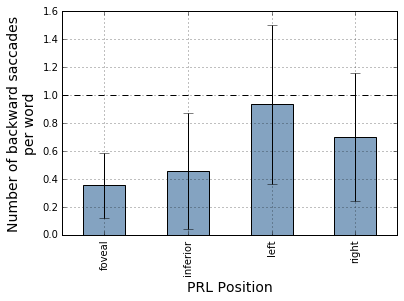

In [42]:
variable='ltor_word'
#foveal_data=merged_df_saccade.query("(Training_x==False) & PRL_Position_x=='Foveal'").mean()[variable]
backward_saccade_data=merged_df_saccade.query("(Training_x==False) & Subject_ID!='S09' ").groupby(['PRL_Position_x']).mean()[variable]
error_bar=merged_df_saccade.query("(Training_x==False)").groupby(['PRL_Position_x'])[variable].std()

backward_saccade_data.plot(kind='bar',yerr=error_bar,capsize=5,color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Number of backward saccades\nper word',size=14)
#plt.ylim(0,20)
plt.xlabel('PRL Position',size=14)
#plt.title('Number of forward saccades & PRL Position')

plt.plot([-0.5,3.5],[1,1], 'k--')
plt.grid()
plt.savefig('figures/Backward_prl_pos.pdf',bbox_inches='tight')

# TODO: Do statistical tests

In [ ]:
#merged_df_saccade.plot(kind='bar', yerr=ltor)

In [43]:
#saccade_dataframe["back_per_word"]=saccade_dataframe.Number_of_backward_Saccades/saccade_dataframe.Num_Words
#saccade_dataframe["saccades_per_word"]=saccade_dataframe.Number_of_saccades/saccade_dataframe.Num_Words
#accuracy_dataframe["accuracy_percent"]=(1-accuracy_dataframe.Num_Errors_Trial)*100
#fixation_dataframe["wpm"]=fixation_dataframe.Num_Words/fixation_dataframe.Trial_Duration*60000

variable='Number_of_forward_Saccades'
foveal_data=saccade_df.query("(Training==False) & PRL_Position=='Foveal'").mean()[variable]
backward_saccade_data=saccade_df.query("(Training==False) & Subject_ID=='S06' ").groupby(['PRL_Position']).mean()[variable]
error_bar=saccade_df.query("(Training==False)").groupby(['PRL_Position'])[variable].std()

backward_saccade_data.plot(kind='bar',yerr=error_bar,capsize=5,color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Number of Regressions',size=11)
plt.ylim(0,20)
plt.xlabel('PRL Position',size=12)
plt.title('Regressions & PRL Position')

TypeError: Empty 'DataFrame': no numeric data to plot

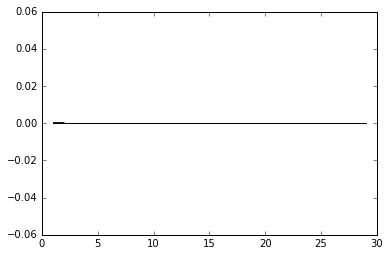

In [44]:
his=[plt.hist((fixation_df.query("Subject_ID=='S0%d'& PRL_Position=='inferior'& Training==False"%(n+1))['Num_Fixations']),
             bins=range(1,30,1))[0] for n in range(6)]

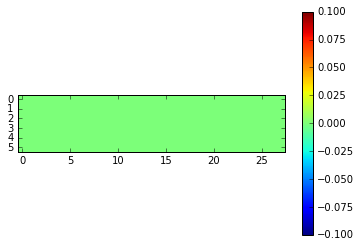

In [45]:
plt.imshow( his, interpolation='nearest'); plt.colorbar()

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

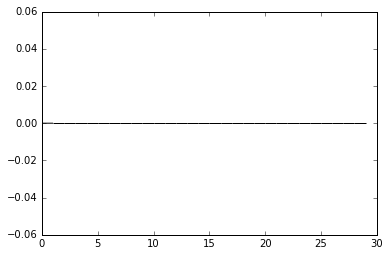

In [46]:
plt.hist((fixation_df.query("Subject_ID=='S0%d'& PRL_Position=='inferior'& Training==False"%(n+1))['Num_Fixations']),
             bins=range(30))

In [47]:
trial_duration_file=open(r"D:\projects_d\Experiment King Devick Reading\reading\Results\Experiment 3 R vs L\All Subjects\Raw Data\S01\PRL Inferior\Session 1\Simulated\trial_duration_file_page8_S01_1_T4_000.txt")
trial_duration=trial_duration_file.readlines()

In [ ]:
int(trial_duration[0][0])

In [78]:
sample_data2_1=merged_df_saccade.query("Training_x==False & Subject_ID!='S07'")
sample_data2_2=merged_df_saccade.query("Training_x==False& PRL_Position_x=='right' & Subject_ID!='S07'")

In [79]:
sample_data2_1.loc[:,"Unique_Trial_Code"]=sample_data2_1.Filename_x.apply(lambda x :x[6:])

In [80]:
data2_1 = sample_data2_1.groupby(["Unique_Trial_Code","PRL_Position_x","Subject_ID"]).sum().reset_index()
data2_1.loc[:,"rtol_per_word"]=data2_1.Number_of_backward_Saccades/data2_1.Number_Words
data2_1.loc[:,"ltor_per_word"]=data2_1.Number_of_forward_Saccades/data2_1.Number_Words

In [81]:
import seaborn as sns

In [82]:
data2_1.query("PRL_Position_x=='right' & Subject_ID=='S02'")["rtol_per_word"].std()

0.1583530379860354

In [83]:
data2_1.Mean_Saccade_Amplitude_H

AttributeError: 'DataFrame' object has no attribute 'Mean_Saccade_Amplitude_H'

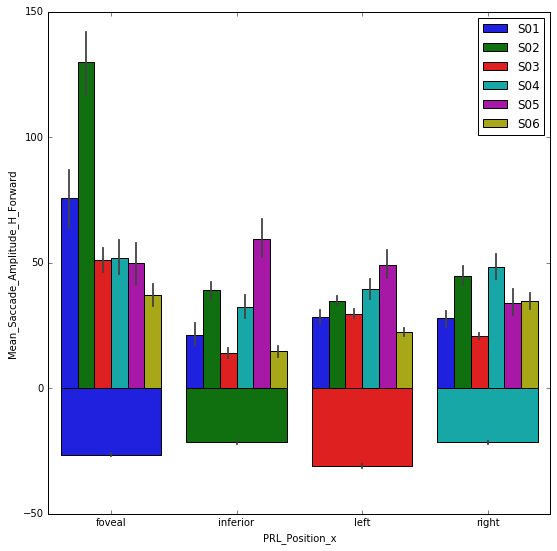

In [84]:
plt.figure(figsize=(9,9))
sns.barplot(x="PRL_Position_x", y="Mean_Saccade_Amplitude_H_Backward", data=data2_1) #,  hue="Subject_ID")
sns.barplot(x="PRL_Position_x", y="Mean_Saccade_Amplitude_H_Forward", data=data2_1, hue="Subject_ID")
plt.legend(loc='upper right')

C:\Users\C-LAB\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\C-LAB\Anaconda2\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\C-LAB\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6016: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


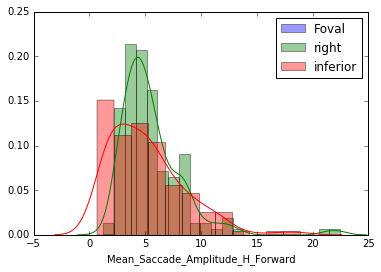

In [59]:
sns.distplot( sample_data2_1.query("Subject_ID=='S02' & PRL_Position_x=='Foveal' &  Mean_Saccade_Amplitude_H_Forward>0")
                   ["Mean_Saccade_Amplitude_H_Forward"], label='Foval') 

sns.distplot( sample_data2_1.query("Subject_ID=='S02' & PRL_Position_x=='right'&  Mean_Saccade_Amplitude_H_Forward>0 ")
                   ["Mean_Saccade_Amplitude_H_Forward"], label='right') 


sns.distplot( sample_data2_1.query("Subject_ID=='S02' & PRL_Position_x=='inferior'&  Mean_Saccade_Amplitude_H_Forward>0 ")
                   ["Mean_Saccade_Amplitude_H_Forward"], label='inferior') 

plt.legend(loc='best')

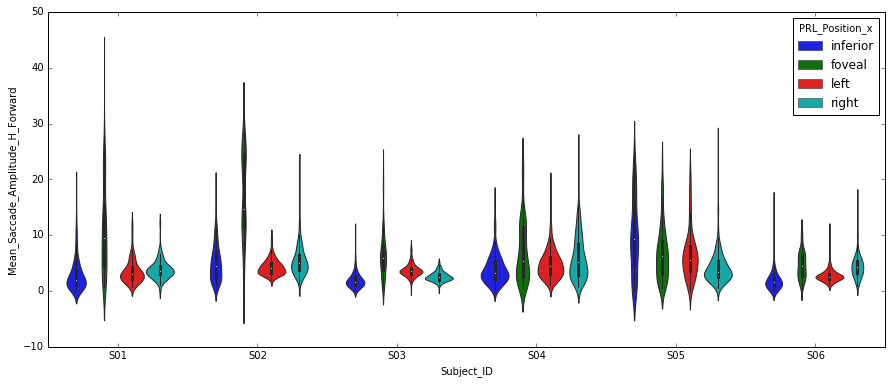

In [60]:
plt.figure(figsize=(15,6))
sns.violinplot(data=sample_data2_1, y='Mean_Saccade_Amplitude_H_Forward', x='Subject_ID', hue='PRL_Position_x')

In [61]:
sample_data2_1.mean()

Unnamed: 0                           39.490605
Session_No                                 inf
Trial_No                                   inf
Training_x                            0.000000
Training_Trial_Number                 4.490605
Mean_Saccade_Duration                50.336855
SD_saccade_duration                  17.209384
Number_of_saccades                   12.185543
Number_of_forward_Saccades            3.389614
Number_of_backward_Saccades           8.795929
Mean_Saccade_Amplitude_H_Forward      5.463700
SD_Saccade_Amplitude_H_Forward        2.711836
Mean_Saccade_Amplitude_H_Backward    -3.131252
SD_Saccade_Amplitude_H_Backward       1.449613
Mean_Saccade_Amplitude_V              0.449539
SD_Saccade_Amplitude_V                0.379383
Page_Num                                   inf
Number_Letters                       29.057933
Number_Words                          5.734864
Page_Number                           4.500000
ltor_word                             0.609850
rtol_word    

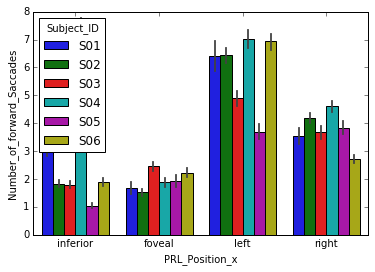

In [62]:
sns.barplot(x="PRL_Position_x",  y="Number_of_forward_Saccades", data=merged_df_saccade, hue='Subject_ID' )

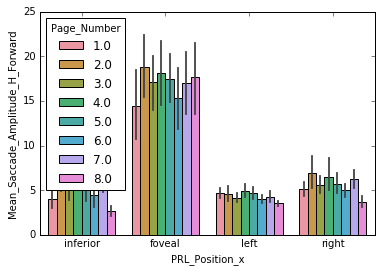

In [63]:
sns.barplot(x="PRL_Position_x", y="Mean_Saccade_Amplitude_H_Forward",
            data=sample_data2_1.query("Subject_ID=='S02'"), hue='Page_Number' )

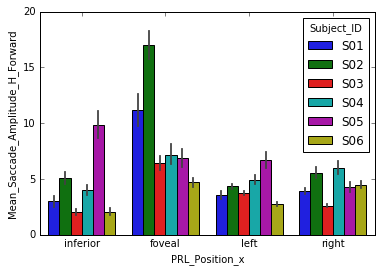

In [64]:
sns.barplot(x="PRL_Position_x", y="Mean_Saccade_Amplitude_H_Forward", data=sample_data2_1, hue="Subject_ID") 

In [65]:
sns.distplot(y="Mean_Saccade_Amplitude_H_Forward", data=data2_1, kde=False, rug=True);

TypeError: distplot() got an unexpected keyword argument 'y'

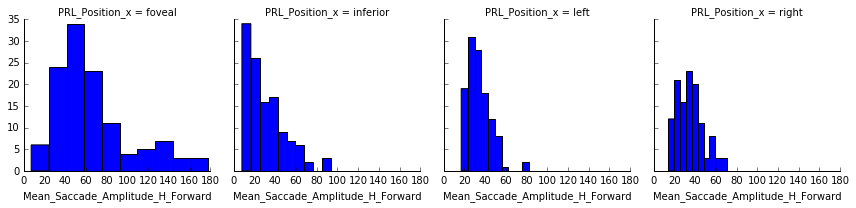

In [66]:
g = sns.FacetGrid(data2_1, col='PRL_Position_x' )
g.map(plt.hist, "Mean_Saccade_Amplitude_H_Forward")


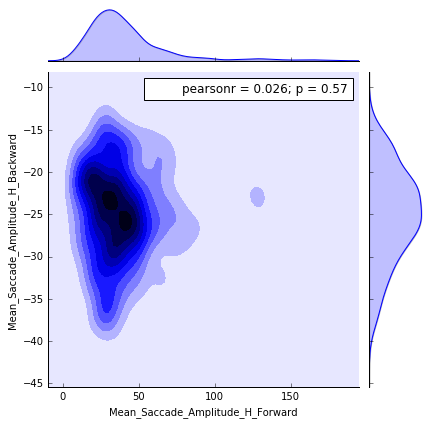

In [67]:
sns.jointplot(x="Mean_Saccade_Amplitude_H_Forward", y="Mean_Saccade_Amplitude_H_Backward", data=data2_1, kind="kde",hue='Subject_ID');

(array([ 113.,  190.,   96.,   42.,   14.,    6.,    5.,    7.,    3.,    3.]),
 array([   6.97964381,   24.09321173,   41.20677965,   58.32034757,
          75.43391549,   92.54748341,  109.66105134,  126.77461926,
         143.88818718,  161.0017551 ,  178.11532302]),
 <a list of 10 Patch objects>)

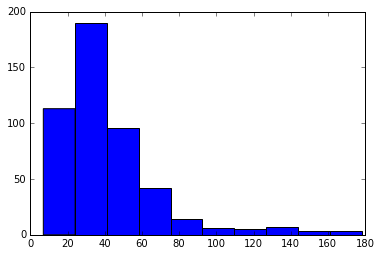

In [68]:
plt.hist( data2_1.Mean_Saccade_Amplitude_H_Forward )

C:\Users\C-LAB\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


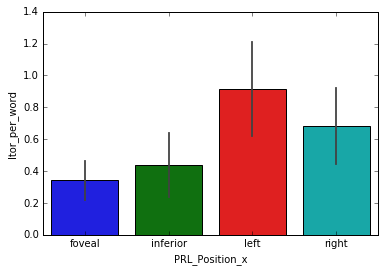

In [69]:
sns.barplot(x="PRL_Position_x", y="ltor_per_word", data=data2_1,  ci="sd")
plt.legend(loc='upper center')

In [85]:
sample_data2_1.group("")

AttributeError: 'DataFrame' object has no attribute 'group'

In [86]:
x=np.array(sample_data2_1.Number_of_backward_Saccades,dtype=int)
y=np.array(sample_data2_1.Number_Words,dtype=float)
#plt.plot(x,y,'o')

np.corrcoef( x,y )[0,1]

0.30571620960898577

In [48]:
from scipy import stats

plt.figure(figsize=(6,6))
x=np.array(sample_data2_1.Number_of_backward_Saccades,dtype=int)
y=np.array(sample_data2_1.Number_Words,dtype=int)

xmin = 1# x.min()
xmax = 30 #x.max()
ymin = 1 #y.min()
ymax = 10 #y.max()

X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
           extent=[xmin, xmax, ymin, ymax], alpha=0.6,interpolation='Nearest')
plt.xlabel('Number Fixation')
plt.ylabel('Number Words')

print( np.corrcoef( x,y )[0,1] )

x=np.array(sample_data2_2.Number_of_backward_Saccades,dtype=int)
y=np.array(sample_data2_2.Number_Words,dtype=int)

xmin = 1# x.min()
xmax = 20 #x.max()
ymin = 1 #y.min()
ymax = 10 #y.max()

X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

#plt.imshow(np.rot90(Z), cmap=plt.cm.afmhot_r,
#           extent=[xmin, xmax, ymin, ymax], alpha=0.6, interpolation='Nearest')
plt.xlabel('Number Fixation')
plt.ylabel('Number Words')

plt.axis('equal')

print( np.corrcoef( x,y )[0,1] )

NameError: name 'sample_data2_1' is not defined

In [87]:
for i in range(len(fixation_df)):
    filename=fixation_df['Filename'][i][6:-4]
    page_num=fixation_df['Page_Num'][i]
    prl_pos=fixation_df['PRL_Position'][i]
    code="%s_%s_%s"%(filename,prl_pos,Page_Num.lower())

KeyError: 'Page_Num'

In [ ]:
fixation_df

In [ ]:
filename='reading_word_data_S01_1_T0_page1.txt'

In [ ]:
fixation_df['Filename'][0][6:-4]

In [72]:
subject_data=num_letters_dataframe#[num_letters_dataframe['Code'].str.contains("S04")]
temp_data=subject_data.query("Training=='False'& Page_Number== '2'& PRL_Position=='left'")#subject_data.query("PRL_Position=='inferior'& Page_Number=='1'")

NameError: name 'num_letters_dataframe' is not defined

In [73]:
fixation_df['Filename'][99][fixation_df['Filename'][99].find('_T')+2:-4]

'9'

In [74]:
merged_df_fixation.Code.unique()

array(['S01_1_T0_inferior_1', 'S01_1_T1_inferior_1', 'S01_1_T2_inferior_1',
       ..., 'S06_0_T7_right_8', 'S06_0_T8_right_8', 'S06_0_T9_right_8'], dtype=object)

In [ ]:
merged_df_fixation.columns

In [ ]:
# def code_without_pageno(x):
#     return "%s_%s_%s"%(x.Subject_ID,x.PRL_Position.lower(),x.Page_Num)

df_fixation_nopage=merged_df_fixation.query('Training_x==False').groupby(["Subject_ID","PRL_Position_x","Session_No","Trial_No"]
                            ).sum()["Number_Words"].reset_index()

In [88]:
def filename_to_code(x):
    return "%s_%s_%s"%(x.Filename[6:-4],x.PRL_Position.lower(),x.Page_Num)

fixation_df["Code"]=fixation_df.apply(filename_to_code,1).astype(str)


AttributeError: ("'Series' object has no attribute 'Page_Num'", u'occurred at index 0')

In [ ]:
df_acc.columns

In [ ]:
df_acc=pd.read_excel('./Grading Sheet Data.xlsx')
df_acc["PRL_Position_x"]=df_acc["PRL_Position"].apply(lambda x:str(x).lower())
#df_acc["Trial_No"]=df_acc["Trial Number"]
df_nopage=df_nopage.convert_objects(convert_numeric=True)

merged_acc=pd.merge(df_acc,df_nopage,on=['Subject_ID','Session_No','PRL_Position_x','Trial_No'])
merged_acc["accuracy_percent"]=(merged_acc.Number_Words-merged_acc.Errors)/merged_acc.Number_Words*100

In [ ]:
plt.figure(figsize=(10,6))
acc_plot=sns.barplot(data=merged_acc,x='Subject_ID',y='accuracy_percent',hue='PRL_Position_x',hue_order=my_order, palette=my_pal)#,hue='Subject_ID')
plt.ylim([94,100.9])
plt.xlabel('Subject ID',size=16)
plt.ylabel('Accuracy (%)',size=16)

plt.legend().set_visible(False)
oursave('Accuracy_Data')

In [ ]:
counter=0
for path in filedir_list:
    for filename in os.listdir(path):
        if 'reading_word_data' in filename :
            counter+=1